<a href="https://colab.research.google.com/github/Keplerzhao/keplerzhao/blob/master/Real_Portfolio_Monitering_System_2_NOV_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tqdm numba statsmodels lmfit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.7/97.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 6.4 MB/s eta 0:00:00


In [2]:
# -*- coding: utf-8 -*-
# EXCF Exponential Fit — Top-3 Accurate Fits (Linear-domain R²)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from scipy.stats import t as student_t
from scipy.optimize import minimize_scalar
import warnings
warnings.filterwarnings('ignore')

# ===============================
# 1) EXCF Detector (improved)
# ===============================
class EXCFExponentialDetector:
    """EXCF Exponential Growth Detector"""

    def __init__(self, window=120, alpha=0.05, min_obs=6):
        self.window = int(window)
        self.alpha = float(alpha)
        self.min_obs = int(min_obs)

    def _fit_excf(self, prices, P0):
        """OLS (no-const) on linear price domain:
           y_t - P0 = ω1 * (y_{t-1} - P0) + ε_t
           Returns: omega1, p_val(one-sided), r2(linear), se
        """
        if len(prices) < self.min_obs:
            return np.nan, np.nan, np.nan, np.nan

        x = (prices[:-1] - P0).astype(float)
        y = (prices[1:]  - P0).astype(float)

        if len(x) < 3 or np.var(x) == 0:
            return np.nan, np.nan, np.nan, np.nan

        # 2D exog for robustness
        X = x.reshape(-1, 1)
        result = sm.OLS(y, X, hasconst=False).fit()

        omega1 = float(result.params[0])
        se     = float(result.bse[0])
        dof    = int(result.df_resid)

        # One-sided test H1: omega1 > 1
        if se > 0 and dof > 0 and np.isfinite(omega1):
            t_stat = (omega1 - 1.0) / se
            p_val  = float(student_t.sf(t_stat, dof))
        else:
            p_val  = np.nan

        # Linear-domain R² (consistent with model)
        y_pred = x * omega1
        sst = np.sum((y - np.mean(y))**2)
        r2  = 1 - np.sum((y - y_pred)**2) / sst if sst > 0 else np.nan

        return omega1, p_val, r2, se

    def detect_bubbles(self, prices: pd.Series) -> pd.DataFrame:
        """Rolling windows; mark bubble windows with (ω1>1, R²>0.3, p<α)"""
        results = []
        n = len(prices)
        for i in range(0, n - self.min_obs + 1):  # include == min_obs
            end_idx = min(i + self.window, n)
            window_prices = prices.iloc[i:end_idx].values
            if len(window_prices) < self.min_obs:
                continue

            P0 = float(window_prices[0])
            omega1, p_val, r2, se = self._fit_excf(window_prices, P0)

            is_bubble = False
            quality = "poor"

            passes_p = (np.isfinite(p_val) and (p_val < self.alpha))
            if (np.isfinite(omega1) and omega1 > 1.0 and
                np.isfinite(r2) and r2 > 0.30 and passes_p):
                is_bubble = True
                if   r2 > 0.80: quality = "excellent"
                elif r2 > 0.60: quality = "good"
                else:           quality = "acceptable"

            results.append({
                'start': prices.index[i],
                'end': prices.index[end_idx-1],
                'omega1': omega1,
                'p_val': p_val,
                'r_squared': r2,
                'P0': P0,
                'is_bubble': is_bubble,
                'quality': quality
            })

        return pd.DataFrame(results)

# =========================================
# 2) Fit curve in linear domain (robust A)
# =========================================
def fit_excf_exponential(prices: pd.Series, omega1: float, P0: float,
                         method: str = 'optimal', nonneg_A: bool = True):
    """
    Linear-domain fit: P_t = P0 + A * ω1^t
    Returns fitted curve (np.ndarray) and linear-domain R².
    """
    if len(prices) < 2 or not np.isfinite(omega1) or omega1 <= 0:
        return np.full(len(prices), np.nan), np.nan

    t = np.arange(len(prices), dtype=float)
    y = prices.values.astype(float)

    if method == 'simple':
        A = prices.iloc[1] - P0 if len(prices) > 1 else 0.0
        if nonneg_A: A = max(0.0, A)
        curve = P0 + A * (omega1 ** t)

    elif method == 'optimal':
        # Data-scaled bounds for stability
        y_span = float(np.nanmax(y) - np.nanmin(y)) if len(y) else 1.0
        bound  = max(1.0, 10.0 * y_span)
        lo, hi = (0.0, bound) if nonneg_A else (-bound, bound)

        def sse(A):
            pred = P0 + A * (omega1 ** t)
            res  = y - pred
            val  = float(np.dot(res, res))
            if not np.isfinite(val):
                return 1e300
            return val

        try:
            result = minimize_scalar(sse, bounds=(lo, hi), method='bounded')
            A_opt  = float(result.x)
            curve  = P0 + A_opt * (omega1 ** t)
        except Exception:
            A = prices.iloc[1] - P0 if len(prices) > 1 else 0.0
            if nonneg_A: A = max(0.0, A)
            curve = P0 + A * (omega1 ** t)
    else:
        raise ValueError("method must be 'simple' or 'optimal'")

    sst = np.sum((y - np.mean(y))**2)
    r2  = 1 - np.sum((y - curve)**2) / sst if sst > 0 else np.nan
    return curve, r2

# =========================================
# 3) Select Top-3 fits (by linear R²)
# =========================================
def _overlap_ratio(a_start, a_end, b_start, b_end):
    L = max(a_start, b_start); R = min(a_end, b_end)
    inter = max(pd.Timedelta(0), R - L)
    union = (a_end - a_start) + (b_end - b_start) - inter
    return float(inter / union) if union > pd.Timedelta(0) else 0.0

def select_top_k_fits(prices: pd.Series, signals: pd.DataFrame,
                      k: int = 3, overlap_jaccard: float = 0.6, log_price: bool = True):
    px = prices.astype(float)
    cand = []
    for _, r in signals[signals['is_bubble']].iterrows():
        s, e = pd.to_datetime(r['start']), pd.to_datetime(r['end'])
        omega1 = float(r['omega1']); P0 = float(r['P0'])
        win = px.loc[s:e]
        if len(win) < 3 or not np.isfinite(omega1) or omega1 <= 0:
            continue
        curve, r2 = fit_excf_exponential(win, omega1, P0, method='optimal', nonneg_A=True)
        if np.isnan(curve).all() or not np.isfinite(r2):
            continue
        cand.append({
            "start": s, "end": e, "omega1": omega1, "P0": P0,
            "r2": float(r2),
            "curve": np.log(curve) if log_price else curve,
            "index": win.index
        })
    # Sort by R² (desc)
    cand.sort(key=lambda d: d["r2"], reverse=True)

    # Deduplicate by time-overlap
    chosen = []
    for c in cand:
        ok = True
        for z in chosen:
            if _overlap_ratio(c["start"], c["end"], z["start"], z["end"]) > overlap_jaccard:
                ok = False; break
        if ok:
            chosen.append(c)
        if len(chosen) >= k:
            break
    return chosen

# =========================================
# 4) Plot (Top-3 only)
# =========================================
def plot_excf_exponential_analysis(prices: pd.Series, signals: pd.DataFrame,
                                   title="Bubble Growth Analysis", log_price=True):
    px = prices.copy().astype(float)
    px_plot = np.log(px) if log_price else px
    ylab = "Log Price" if log_price else "Price"

    # Bubble mask
    bubble_mask = pd.Series(False, index=px.index)
    for _, row in signals[signals['is_bubble']].iterrows():
        mask = (px.index >= row['start']) & (px.index <= row['end'])
        bubble_mask.loc[mask] = True

    # ω1 series (aligned by window end)
    omega_series = pd.Series(index=px.index, dtype=float)
    for _, row in signals.iterrows():
        omega_series.loc[row['end']] = row['omega1']
    omega_series = omega_series.reindex(px.index).interpolate().ffill().bfill()

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 8),
                                        gridspec_kw={"height_ratios": [2, 1, 2.5]})

    # Panel 1: price + bubble shading
    ax1.plot(px_plot.index, px_plot.values, 'navy', linewidth=1.5, label='Price series')
    ax1.set_ylabel(ylab, fontsize=12)
    ax1.set_title(f"{title} - Price Series & Bubble Detection", fontsize=14, fontweight='bold')
    in_bubble = False; start_bubble = None
    for i, (date, is_bub) in enumerate(bubble_mask.items()):
        if is_bub and not in_bubble:
            start_bubble = date; in_bubble = True
        elif not is_bub and in_bubble:
            ax1.axvspan(start_bubble, date, alpha=0.3, color='lightblue')
            in_bubble = False
    if in_bubble:
        ax1.axvspan(start_bubble, px_plot.index[-1], alpha=0.3, color='lightblue')
    ax1.legend(); ax1.grid(True, alpha=0.3)

    # Panel 2: ω1
    ax2.plot(omega_series.index, omega_series.values, 'green', linewidth=1.5)
    ax2.axhline(1.0, linestyle='--', color='red', label='ω₁ = 1 (critical)')
    ax2.set_ylabel('ω₁ parameter', fontsize=12)
    ax2.set_title('Time Series of Parameter ω₁', fontsize=12)
    ax2.legend(); ax2.grid(True, alpha=0.3)

    # Panel 3: Only Top-3 fits (by linear R²)
    ax3.plot(px_plot.index, px_plot.values, 'navy', linewidth=1.5, alpha=0.7, label='Full price series')
    ax3.set_title('Top 3 Bubble Fits (by linear-domain R²)', fontsize=12, fontweight='bold')

    topfits = select_top_k_fits(prices, signals, k=3, overlap_jaccard=0.6, log_price=log_price)
    colors = plt.cm.tab10(np.linspace(0, 1, max(len(topfits), 1)))
    total_r2, cnt = 0.0, 0

    for i, f in enumerate(topfits):
        color = colors[i % len(colors)]
        ax3.plot(f["index"], f["curve"], color=color, lw=2.6,
                 label=f'{f["start"].strftime("%Y-%m")}→{f["end"].strftime("%Y-%m")} '
                       f'(ω₁={f["omega1"]:.3f}, R²={f["r2"]:.3f})')
        ax3.axvspan(f["start"], f["end"], alpha=0.12, color=color)
        total_r2 += f["r2"]; cnt += 1

    if cnt > 0:
        avg_r2 = total_r2 / cnt
        ax3.text(0.02, 0.98, f'Top-3 avg R²: {avg_r2:.3f}', transform=ax3.transAxes,
                 fontsize=10, va='top', bbox=dict(boxstyle='round', fc='lightyellow', alpha=0.9))

    ax3.set_ylabel(ylab, fontsize=12); ax3.set_xlabel('Date', fontsize=12)
    ax3.grid(True, alpha=0.3)

    for ax in [ax1, ax2, ax3]:
        ax.tick_params(axis='x', rotation=0)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.tight_layout(); plt.show()

# =========================================
# 5) Pipeline: fetch → weekly → detect → plot
# =========================================
def excf_from_symbol(
    sym: str,
    start: str,
    end: str,
    api_key: str,
    *,
    window: int = 100,
    alpha: float = 0.05,
    min_obs: int = 10,
    week_rule: str = "W-FRI",
    log_price: bool = False,
    show_info: bool = True
):
    """
    从 FMP 拉取 {sym} 的收盘价（周频），运行 EXCF 并仅绘制 Top-3 拟合
    """
    import requests

    start_ts = pd.to_datetime(start).normalize()
    end_ts   = pd.to_datetime(end).normalize()
    sym = str(sym).upper()

    url = (f"https://financialmodelingprep.com/api/v3/historical-price-full/"
           f"{sym}?from={start_ts.date()}&to={end_ts.date()}&serietype=line&apikey={api_key}")
    r = requests.get(url, timeout=15); r.raise_for_status()
    js = r.json().get("historical", [])
    if not js:
        raise ValueError("❌ API 无返回，请检查 symbol、日期或 API key。")

    daily = (pd.DataFrame(js)
             .assign(date=lambda d: pd.to_datetime(d["date"]))
             .set_index("date")
             .sort_index()
             .loc[start_ts:end_ts, ["close"]])
    if daily.empty:
        raise ValueError("❌ 本地切片后无数据，请检查起止日期与交易所日历。")

    weekly = daily["close"].resample(week_rule).last().dropna()

    if show_info:
        print(f"[INFO] {sym}: {weekly.index.min().date()} → {weekly.index.max().date()}  (n={len(weekly)})")
        print(f"[INFO] 周终规则: {week_rule}")

    detector = EXCFExponentialDetector(window=window, alpha=alpha, min_obs=min_obs)
    signals  = detector.detect_bubbles(weekly)

    plot_excf_exponential_analysis(
        weekly,
        signals,
        title=f"{sym} Growth Bubble Analysis",
        log_price=log_price
    )

    if show_info and not signals.empty:
        bub = signals.loc[signals["is_bubble"]]
        print(f"Detected bubbles: {len(bub)} / {len(signals)} windows")
        if len(bub) > 0:
            print(f"Avg ω₁: {bub['omega1'].mean():.4f} | Avg R²: {bub['r_squared'].mean():.4f}")

    return signals


In [3]:

# -*- coding: utf-8 -*-
# ===============================================================
# GSADF (PSY 2015) 一键分析函数 — 输入 symbol → 自动绘图
# ===============================================================

import requests, pandas as pd, numpy as np
import matplotlib.pyplot as plt, matplotlib.dates as mdates
import math, warnings, sys
from numba import njit
warnings.filterwarnings("ignore")

API_KEY = "490ed0ef6adef36a548539c3e6da425e"

# ---------- 95% 临界值稀疏表 ------------------------------
TAU_GRID  = np.array([0.20,0.25,0.30,0.35,0.40,0.45,
                      0.50,0.55,0.60,0.65,0.70])
CV95_GRID = np.array([2,2,2,2,2,2,2,2,2,2,2])

def cv_sequence_95(T: int) -> np.ndarray:
    tau = np.arange(T) / T
    tau[tau < TAU_GRID[0]] = TAU_GRID[0]
    tau[tau > TAU_GRID[-1]] = TAU_GRID[-1]
    return np.interp(tau, TAU_GRID, CV95_GRID)


# ---------- Numba 实现的 ADF 与 Rolling-BSADF ----------------
@njit
def _adf_no_const(y, k):
    n  = y.size
    dy = y[1:] - y[:-1]
    rows = n - 1 - k
    if rows <= k:
        return -1e9
    X = np.empty((rows, 1 + k))
    X[:, 0] = y[k:-1]
    for i in range(1, k + 1):
        X[:, i] = dy[k-i:-i]
    Y = dy[k:]
    XtX   = X.T @ X
    beta  = np.linalg.solve(XtX, X.T @ Y)
    resid = Y - X @ beta
    sigma2 = (resid @ resid) / (rows - X.shape[1])
    var_b0 = sigma2 * np.linalg.inv(XtX)[0, 0]
    return beta[0] / math.sqrt(var_b0)

@njit
def rolling_bsadf_numba(logp, min_win):
    T      = logp.size
    bsadf  = np.full(T, np.nan)
    for r2 in range(min_win, T):
        sup_t = -1e9
        for r1 in range(0, r2 - min_win + 1):
            y = logp[r1:r2+1]
            k = int(1.5 * y.size ** (1/3))
            sup_t = max(sup_t, _adf_no_const(y, k))
        bsadf[r2] = sup_t
    return bsadf


# ===============================================================
# 主函数：输入 symbol 自动绘图
# ===============================================================
def run_gsadf(symbol="601288.SS", start="2022-01-01", end="2025-10-31"):
    """执行 GSADF 检测并绘图"""
    # --- 1. 拉取数据 ---
    url = (f"https://financialmodelingprep.com/api/v3/historical-price-full/"
           f"{symbol}?from={start}&to={end}&serietype=line&apikey={API_KEY}")
    js  = requests.get(url, timeout=15).json().get("historical", [])
    if not js:
        raise ValueError(f"❌ API 无返回，请检查 symbol {symbol} 或 API key。")

    daily = (pd.DataFrame(js)
             .assign(date=lambda d: pd.to_datetime(d["date"]))
             .set_index("date").sort_index())
    price = daily["close"].resample("W").last().dropna()

    logp  = np.log(price.values)
    dates = price.index
    T     = len(price)

    # --- 2. 最小窗口 ---
    r0_formula = 0.01 + 1.8 / np.sqrt(T)
    MIN_WIN    = math.ceil(r0_formula * T)

    print(f"Sample T={T}, r0={r0_formula:.4f}, MIN_WIN={MIN_WIN}")

    # --- 3. 计算 BSADF ---
    bsadf = rolling_bsadf_numba(logp, MIN_WIN)

    # --- 4. GSADF & 泡沫标记 ---
    cv95_seq = cv_sequence_95(T)
    gsadf    = np.nanmax(bsadf)
    bflag    = bsadf > cv95_seq

    print(f"{symbol}: GSADF={gsadf:.3f} | Bubble Count={bflag.sum()}")

    # --- 5. 泡沫区段 ---
    bubble_periods = []
    start_b = None
    for d, f in zip(dates, bflag):
        if f and start_b is None:
            start_b = d
        elif not f and start_b is not None:
            bubble_periods.append((start_b, d))
            start_b = None
    if start_b is not None:
        bubble_periods.append((start_b, dates[-1]))

    # --- 6. 绘图 ---
        # --- 6. 绘图 ---
    # 更宽的图形比例 & 提高清晰度
    fig, (ax1, ax2) = plt.subplots(
        2, 1,
        figsize=(15, 6),                  # 图像大小（宽20英寸，高10英寸）
        sharex=True,
        gridspec_kw={'height_ratios': [2.5, 1]}
    )
    # plt.rcParams['figure.dpi'] = 150       # 图像分辨率

    # === 上图：价格序列 + 泡沫区间 ===
    ax1.plot(dates, price, color="black", linewidth=1.5, label="Weekly Close Price")
    for s, e in bubble_periods:
        ax1.axvspan(s, e, color="gray", alpha=0.3)
    ax1.set_title(f"{symbol} —  Bubble Detection (Weekly Data)",
                  fontsize=15, fontweight='bold')
    ax1.set_ylabel("Price (log scale optional)", fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # === 下图：BSADF 序列 + 临界值 ===
    ax2.plot(dates, bsadf, color="purple", linewidth=1.3, label="BSADF Statistic")
    ax2.plot(dates, cv95_seq, color="blue", linestyle="--", linewidth=1.2, label="95% Critical Value")
    for s, e in bubble_periods:
        ax2.axvspan(s, e, color="gray", alpha=0.3)
    ax2.set_ylabel(" Value (t-statistic)", fontsize=12)
    ax2.set_xlabel("Date", fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # === 坐标轴与时间格式 ===
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=0)

    plt.tight_layout()
    plt.show()


In [4]:
Portfolio=['MU','LFSC','HVAC','APH','ACES','NXT','TRVI','POWL','SSM.AX','PAXX.AX','VESG.AX','SRV.AX','IEM.AX','ALB','VMI','MU','NVDA','AYI','SCCO','GOOG','ANET','MPWR','GLL','FSLR','AMX','QCLN','AA']


In [6]:
Portfolio=['ECG','VRDN','PII','MS','CIB','AMX','CYBR','WFRD','ESE','ADPT','IFS','SRV.AX','ROG']

Sample T=53, r0=0.2572, MIN_WIN=14
ECG: GSADF=5.602 | Bubble Count=18


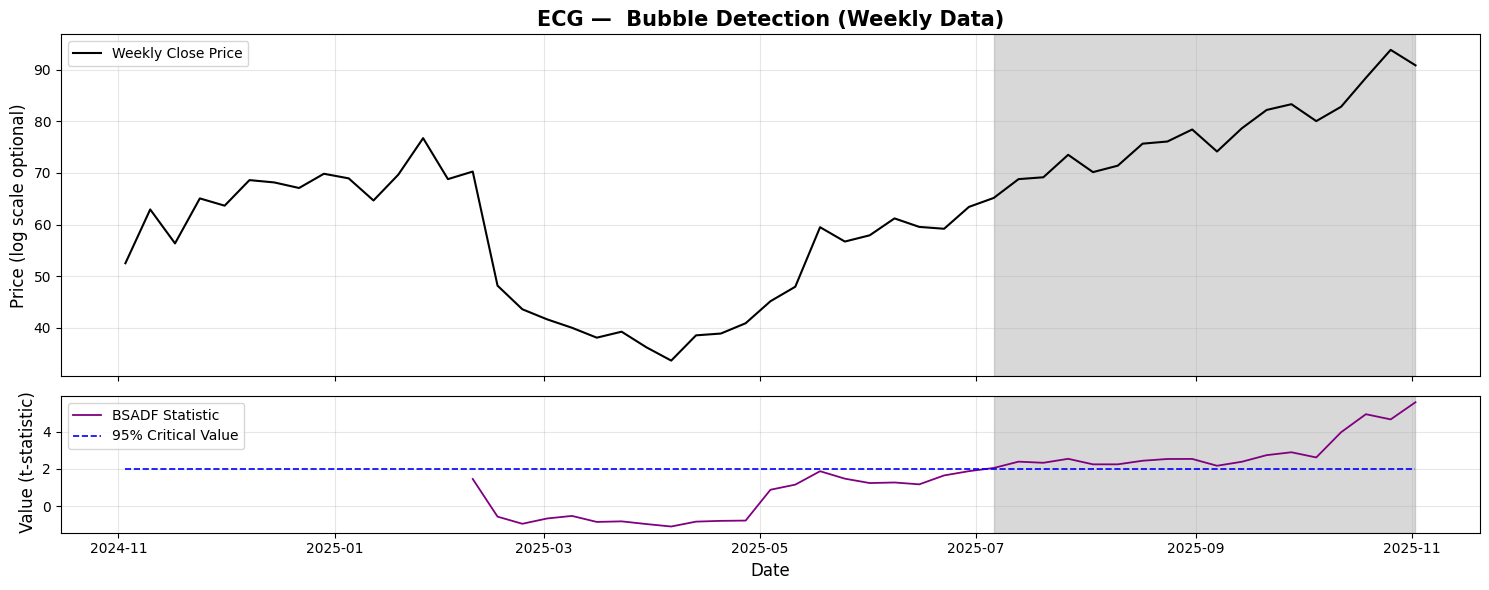

[INFO] ECG: 2024-11-03 → 2025-11-02  (n=53)
[INFO] 周终规则: W


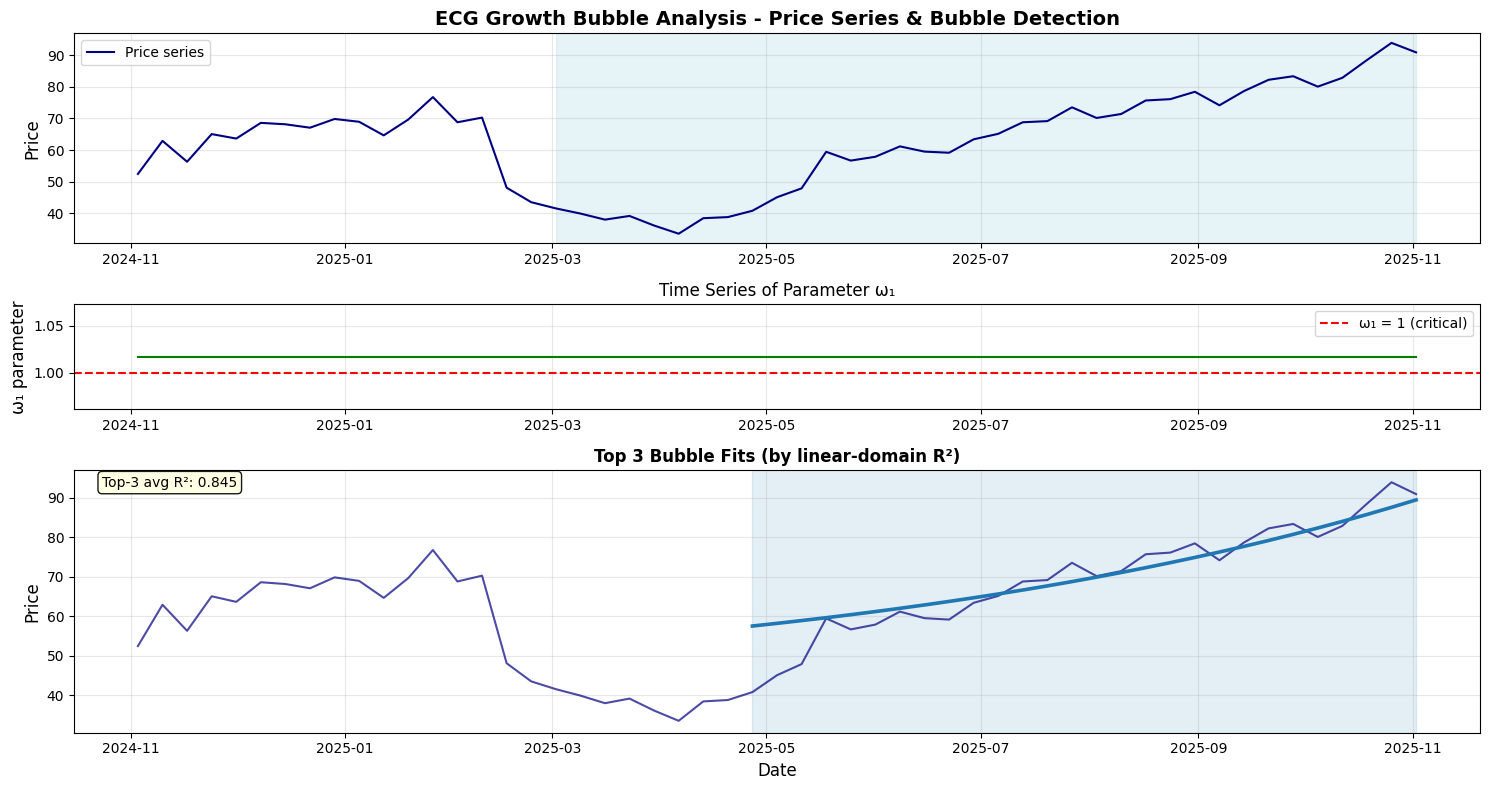

Detected bubbles: 9 / 44 windows
Avg ω₁: 1.0388 | Avg R²: 0.9434
Sample T=200, r0=0.1373, MIN_WIN=28
VRDN: GSADF=3.754 | Bubble Count=9


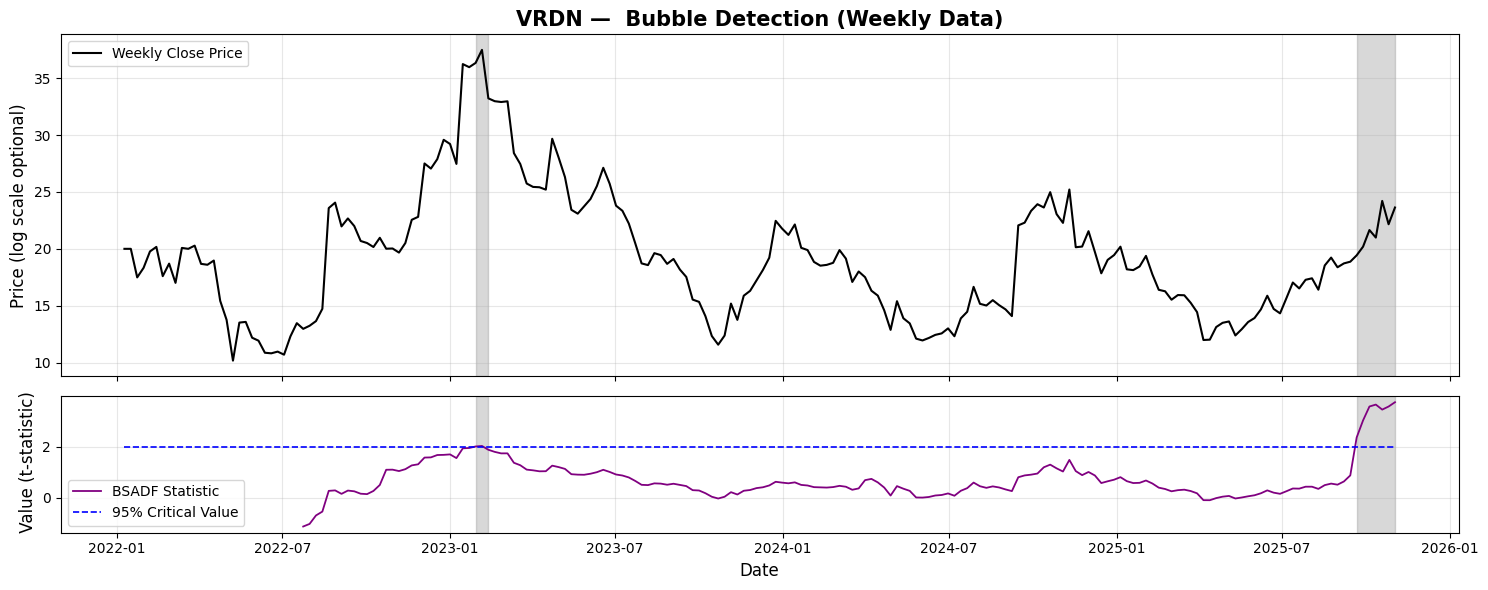

[INFO] VRDN: 2022-01-09 → 2025-11-02  (n=200)
[INFO] 周终规则: W


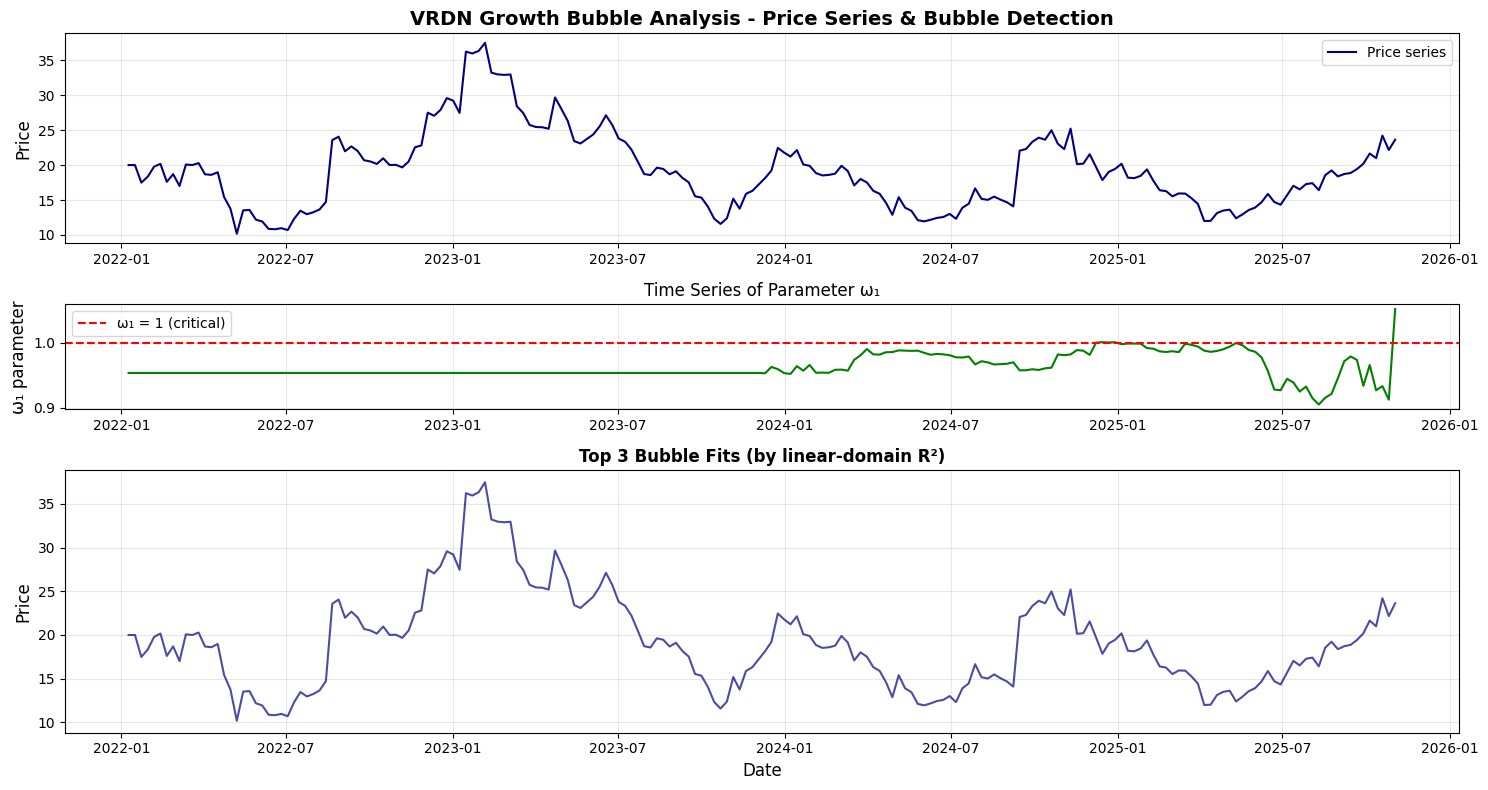

Detected bubbles: 0 / 191 windows
Sample T=200, r0=0.1373, MIN_WIN=28
PII: GSADF=3.258 | Bubble Count=6


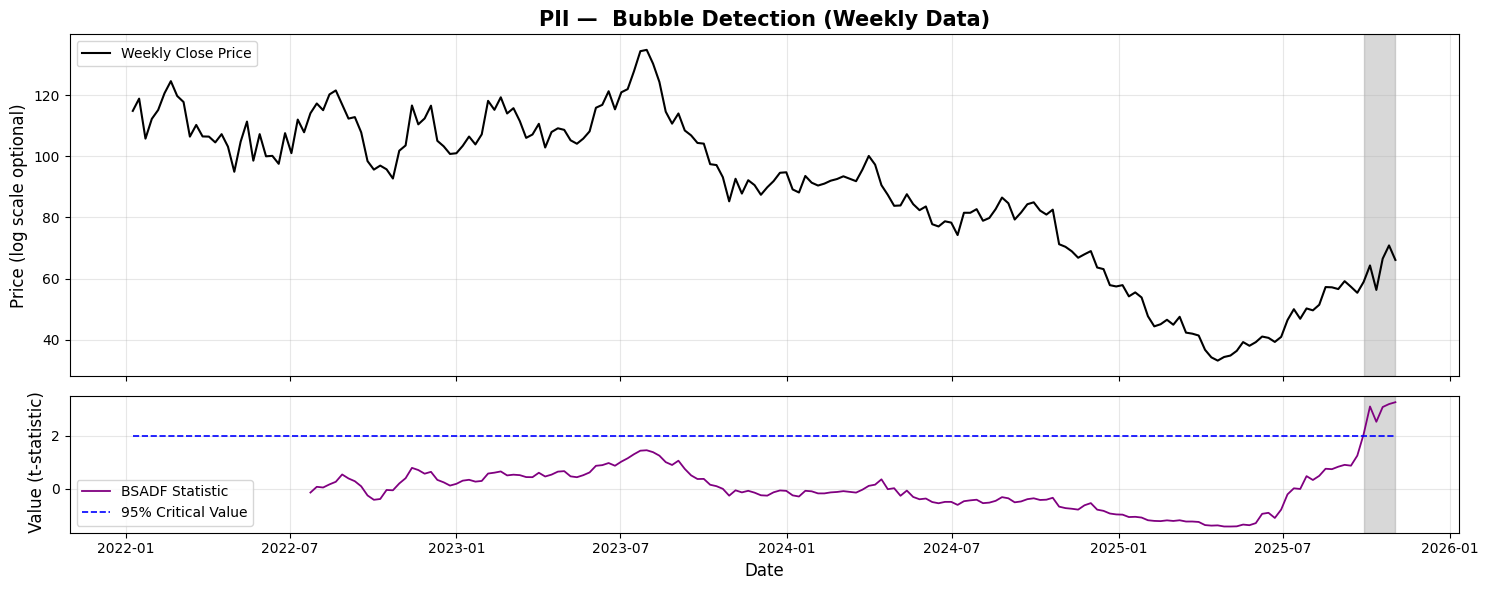

[INFO] PII: 2022-01-09 → 2025-11-02  (n=200)
[INFO] 周终规则: W


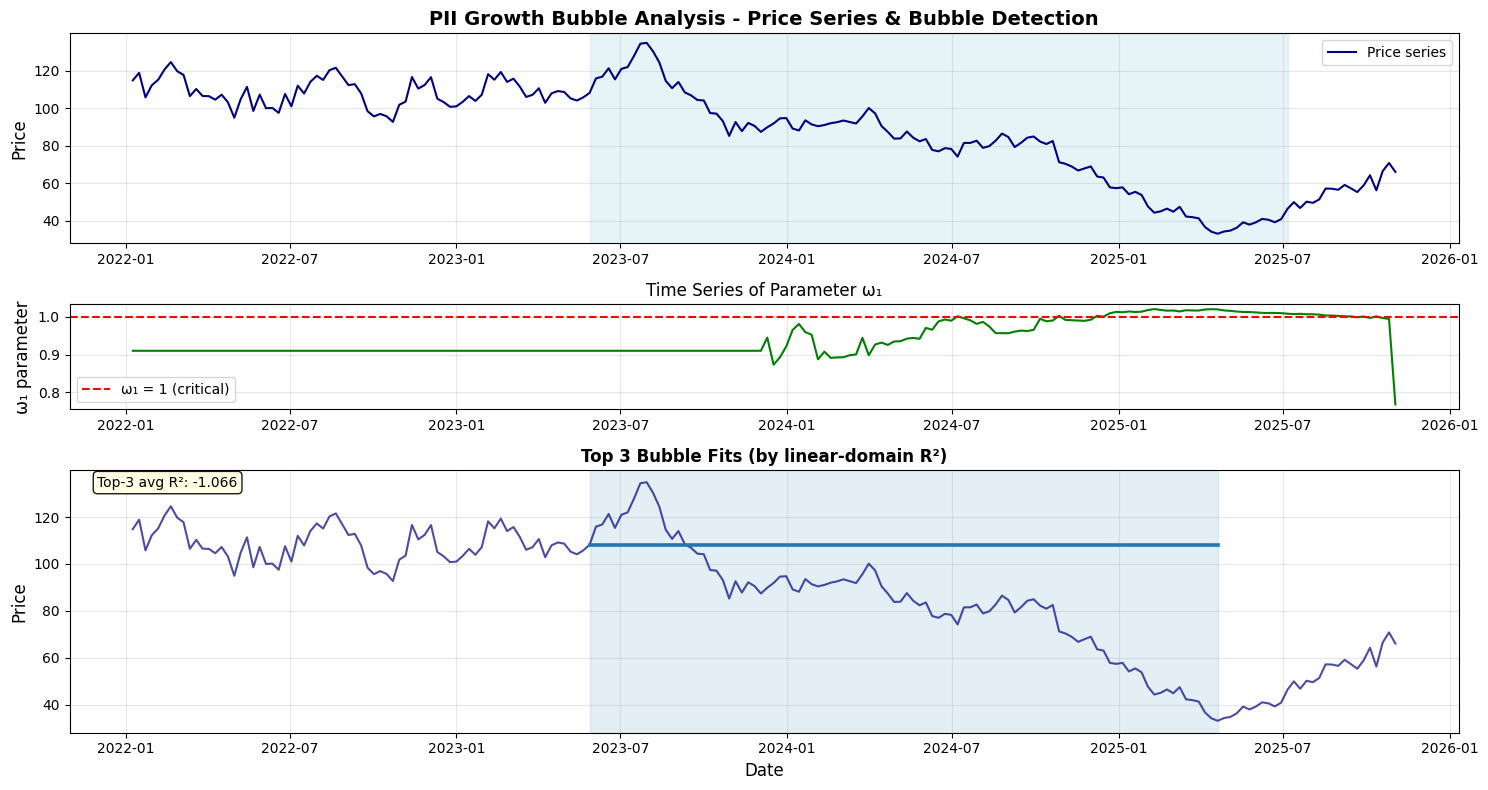

Detected bubbles: 8 / 191 windows
Avg ω₁: 1.0138 | Avg R²: 0.9765
Sample T=200, r0=0.1373, MIN_WIN=28
MS: GSADF=4.030 | Bubble Count=39


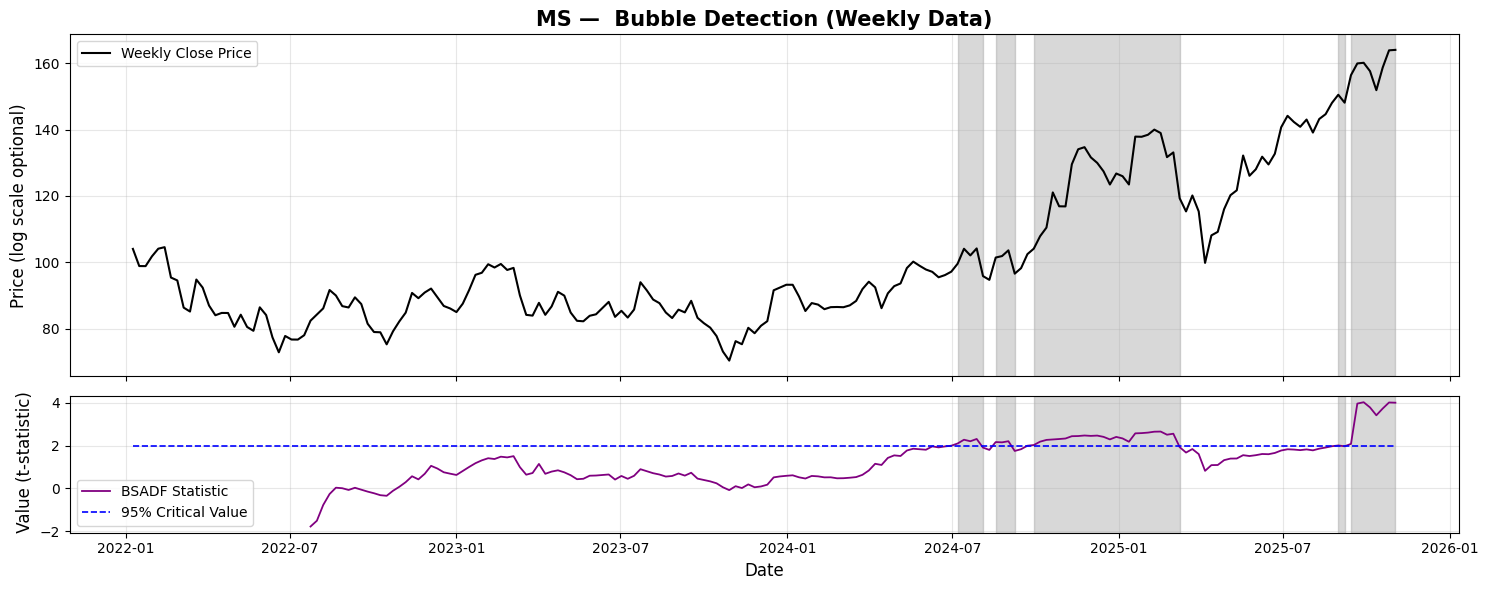

[INFO] MS: 2022-01-09 → 2025-11-02  (n=200)
[INFO] 周终规则: W


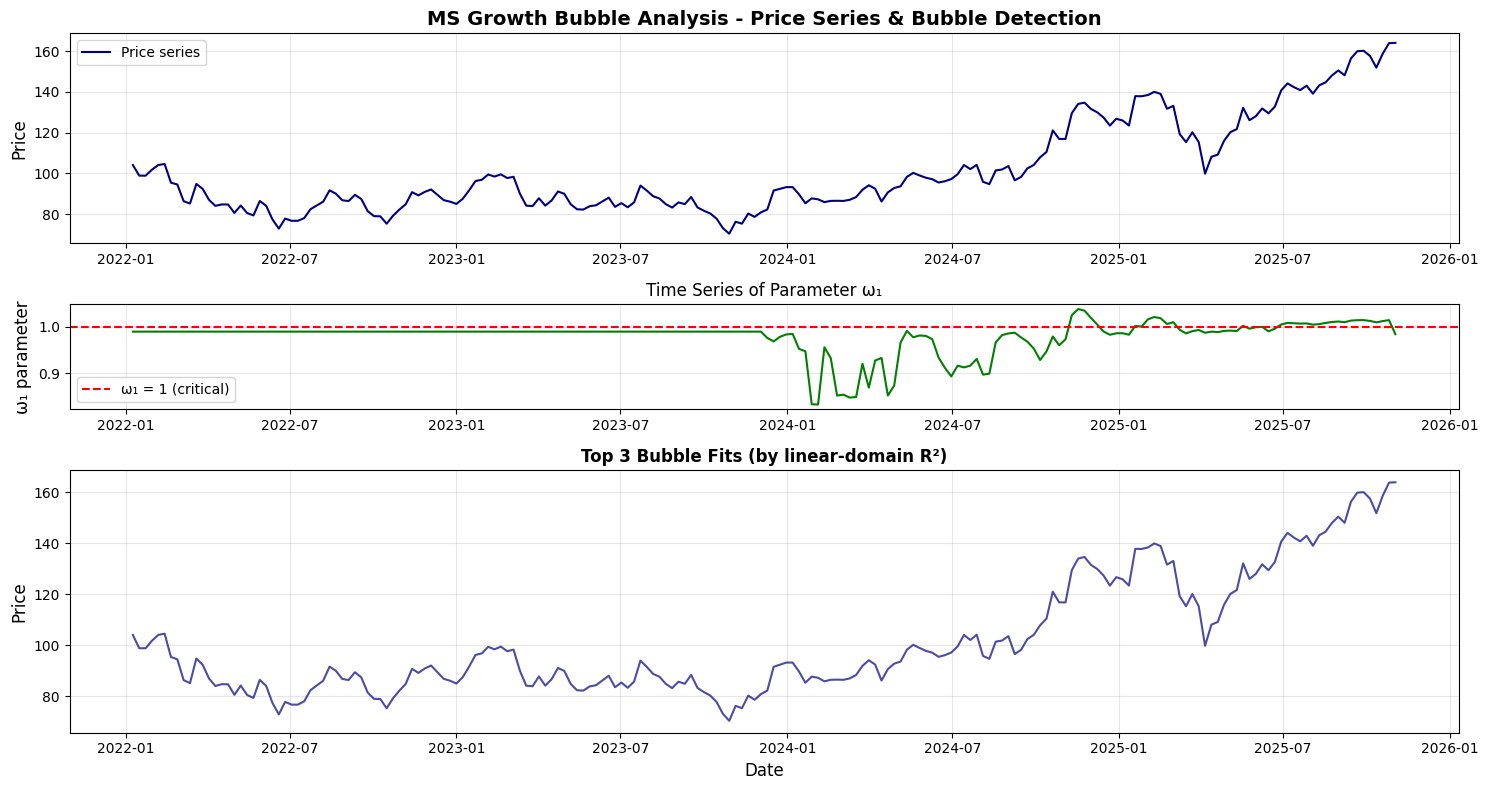

Detected bubbles: 0 / 191 windows
Sample T=200, r0=0.1373, MIN_WIN=28
CIB: GSADF=3.251 | Bubble Count=31


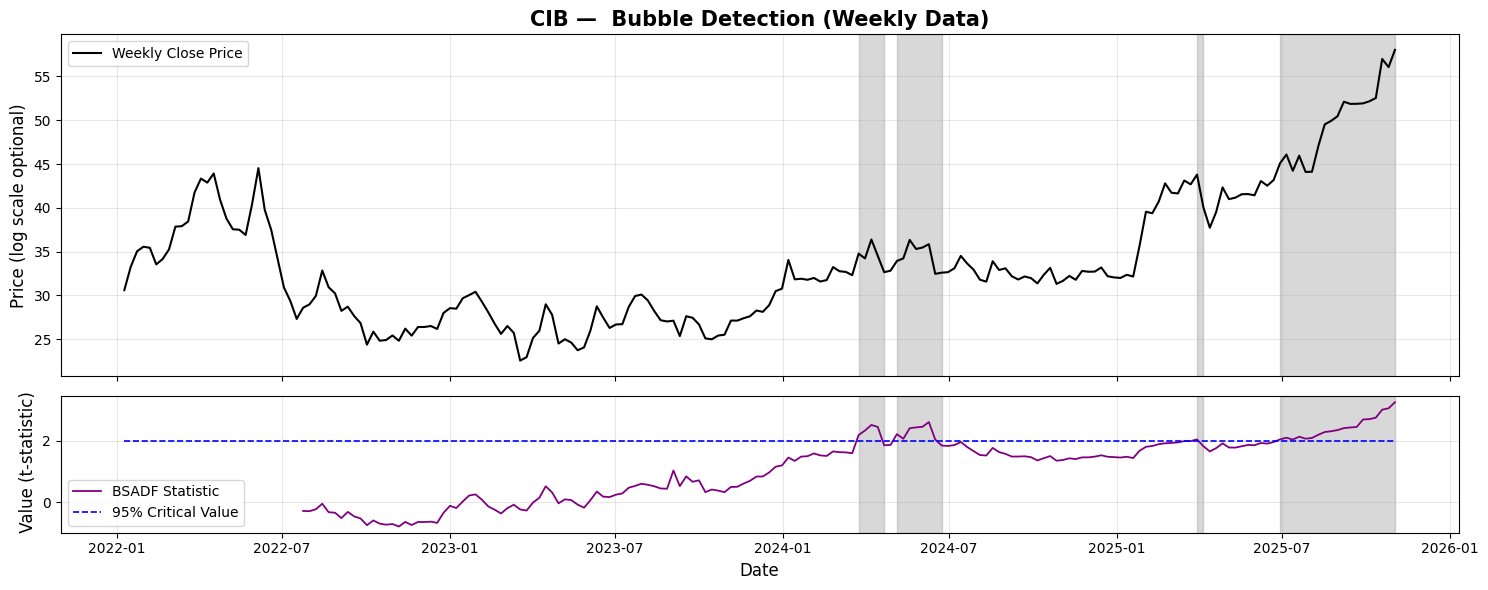

[INFO] CIB: 2022-01-09 → 2025-11-02  (n=200)
[INFO] 周终规则: W


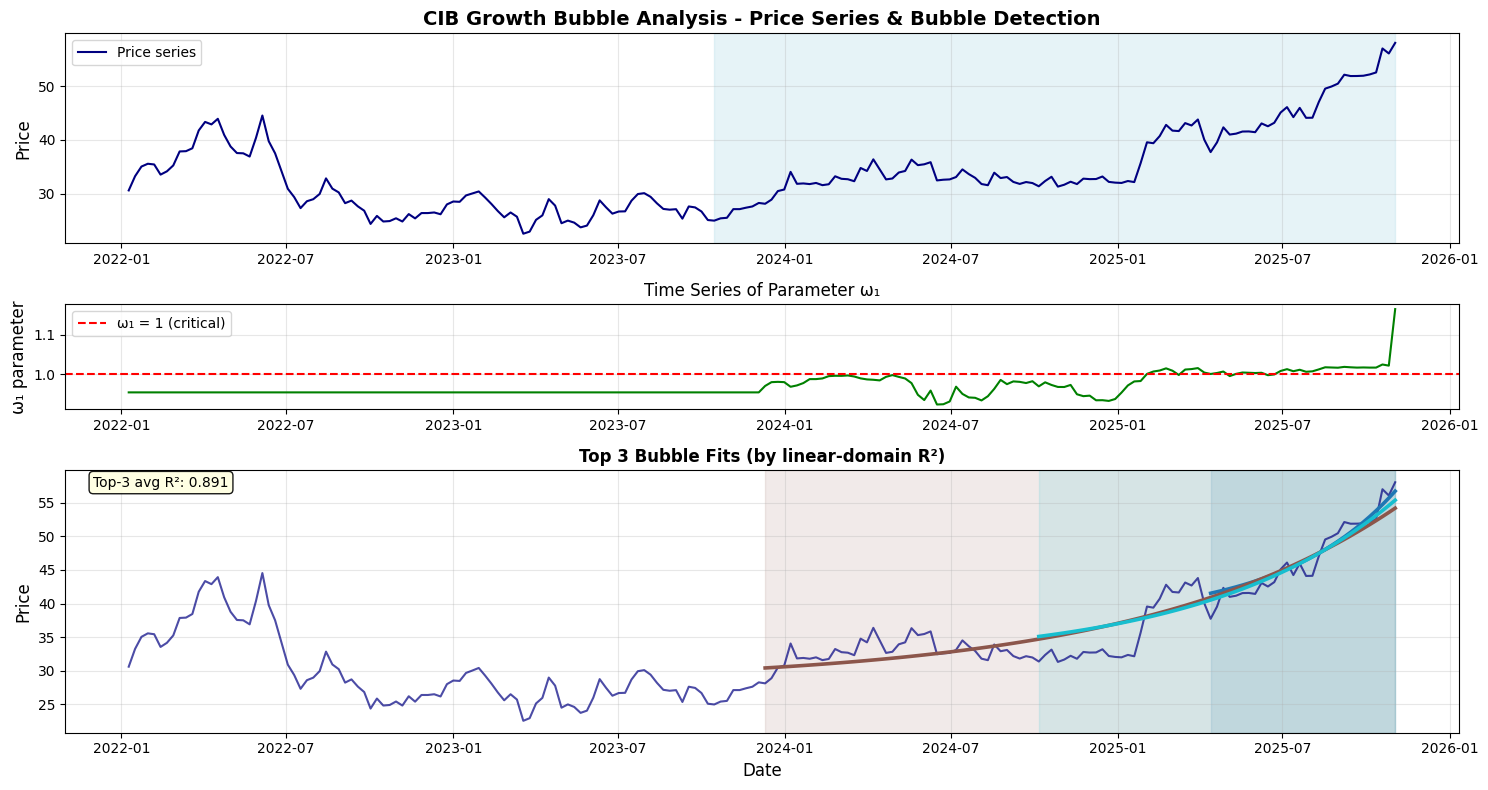

Detected bubbles: 68 / 191 windows
Avg ω₁: 1.0378 | Avg R²: 0.9497
Sample T=200, r0=0.1373, MIN_WIN=28
AMX: GSADF=2.700 | Bubble Count=15


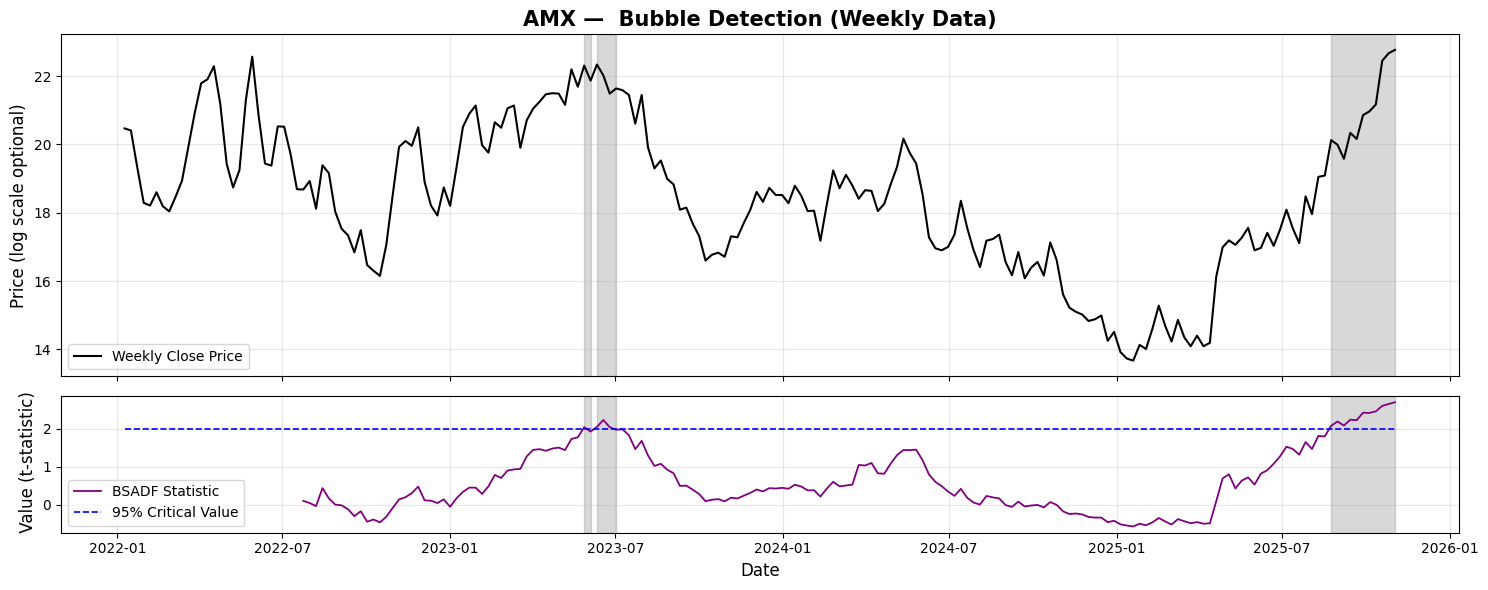

[INFO] AMX: 2022-01-09 → 2025-11-02  (n=200)
[INFO] 周终规则: W


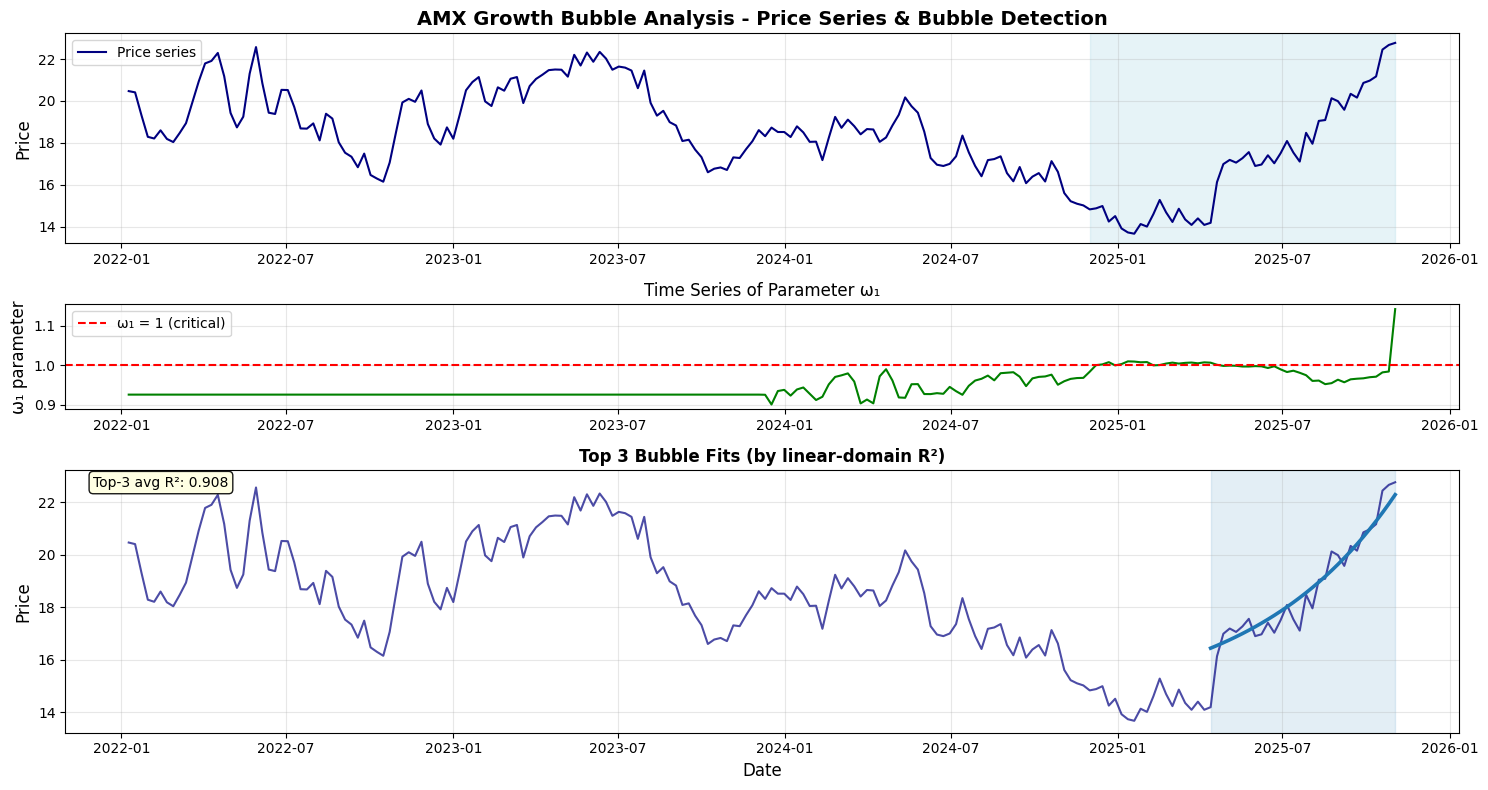

Detected bubbles: 17 / 191 windows
Avg ω₁: 1.0450 | Avg R²: 0.9317
Sample T=200, r0=0.1373, MIN_WIN=28
CYBR: GSADF=4.140 | Bubble Count=107


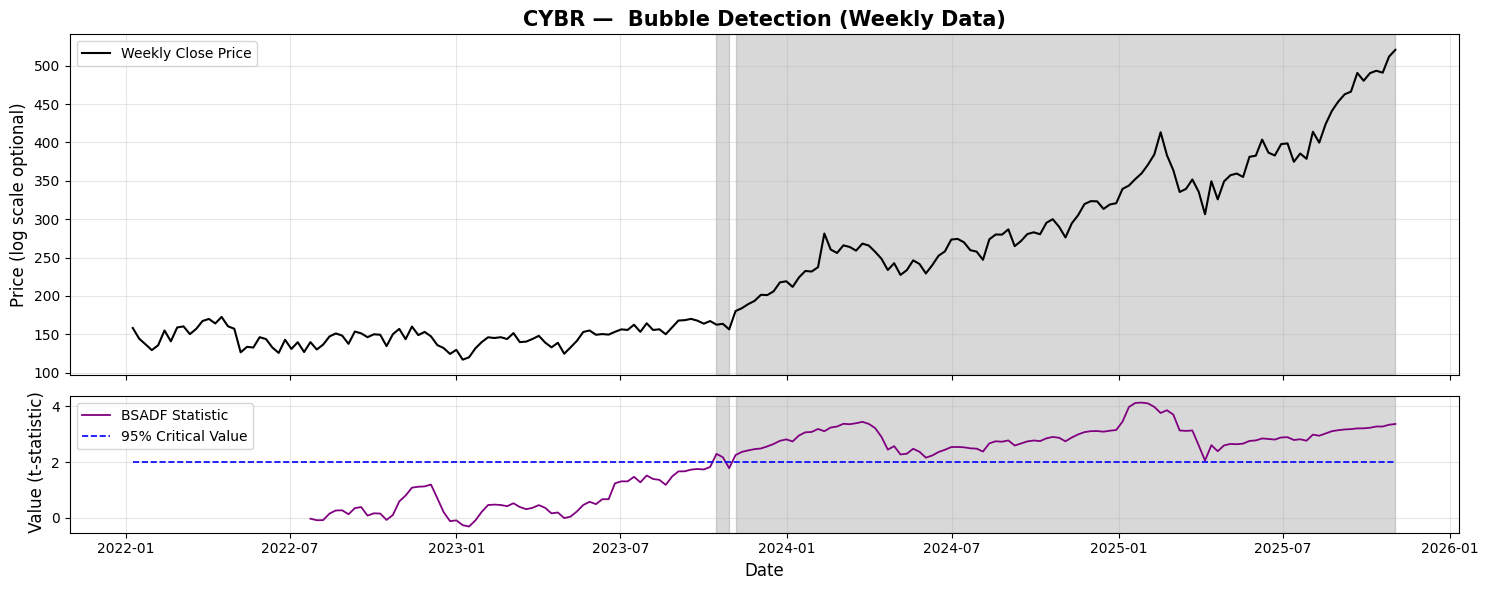

[INFO] CYBR: 2022-01-09 → 2025-11-02  (n=200)
[INFO] 周终规则: W


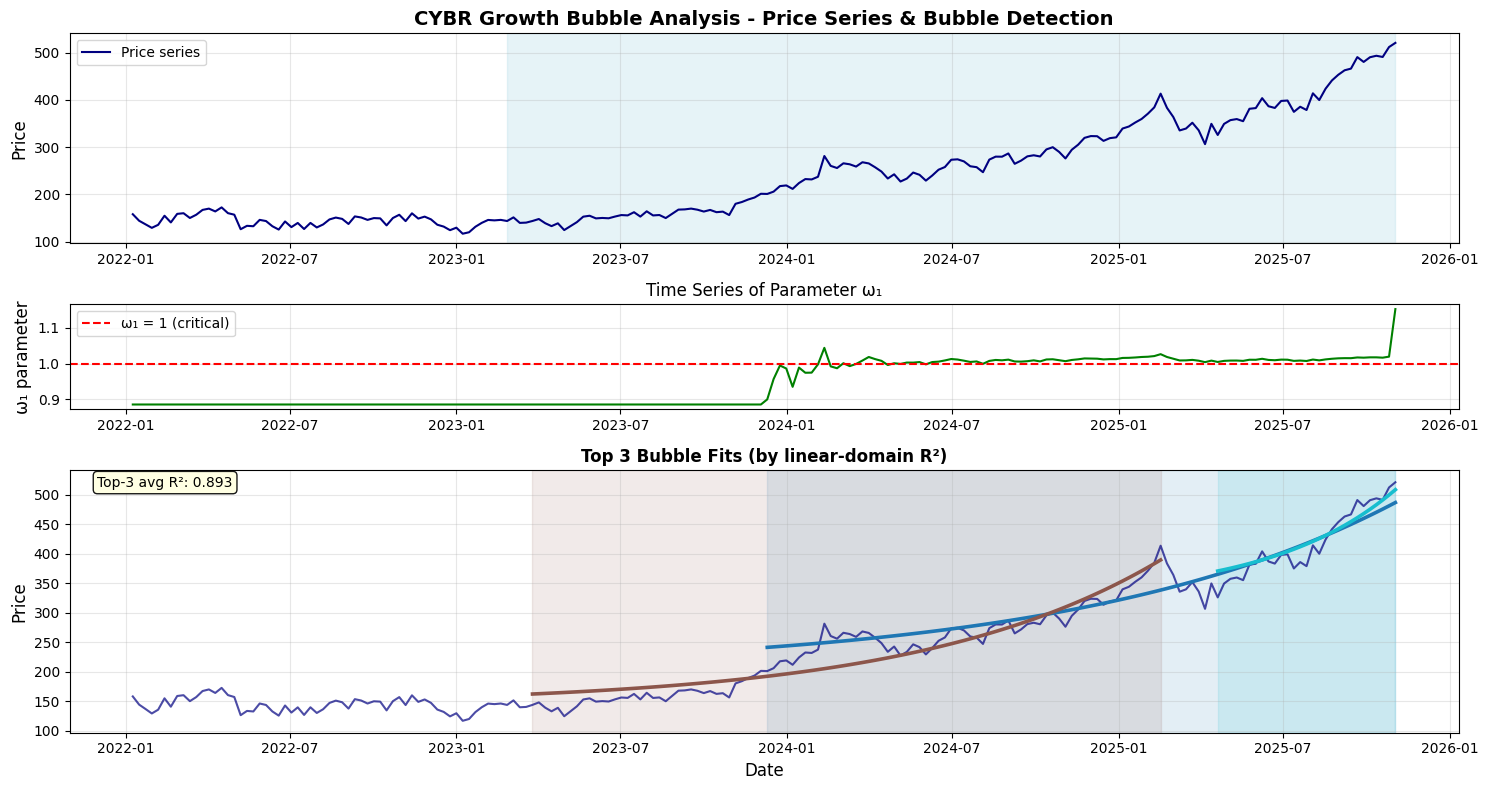

Detected bubbles: 40 / 191 windows
Avg ω₁: 1.0262 | Avg R²: 0.9559
Sample T=200, r0=0.1373, MIN_WIN=28
WFRD: GSADF=4.263 | Bubble Count=102


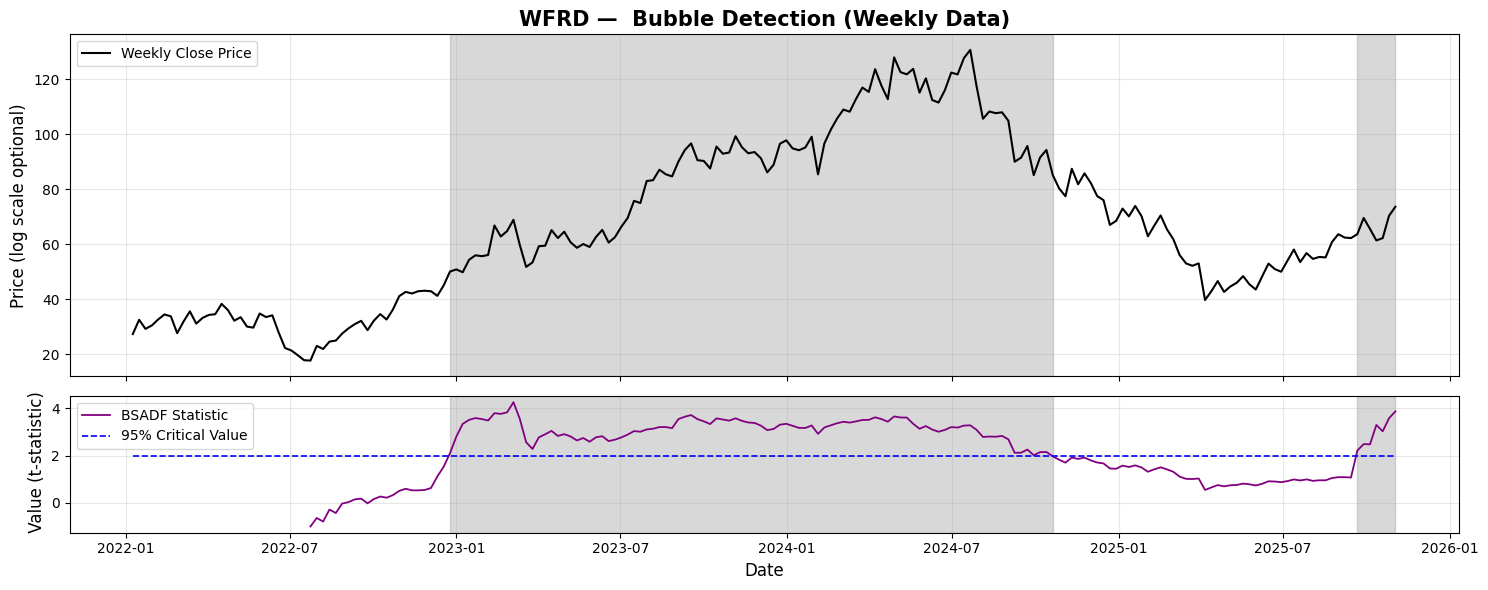

[INFO] WFRD: 2022-01-09 → 2025-11-02  (n=200)
[INFO] 周终规则: W


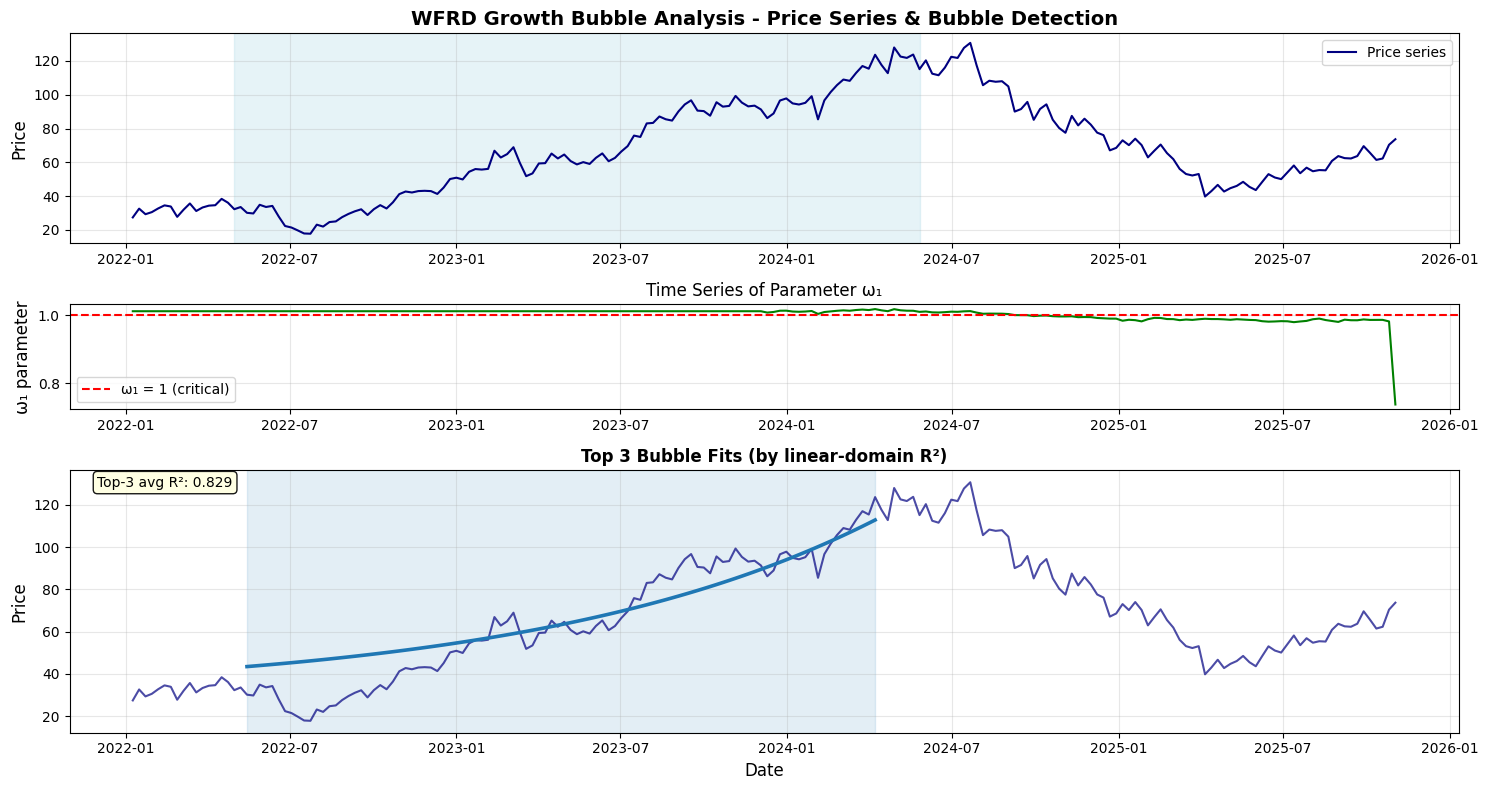

Detected bubbles: 4 / 191 windows
Avg ω₁: 1.0170 | Avg R²: 0.9780
Sample T=200, r0=0.1373, MIN_WIN=28
ESE: GSADF=4.253 | Bubble Count=89


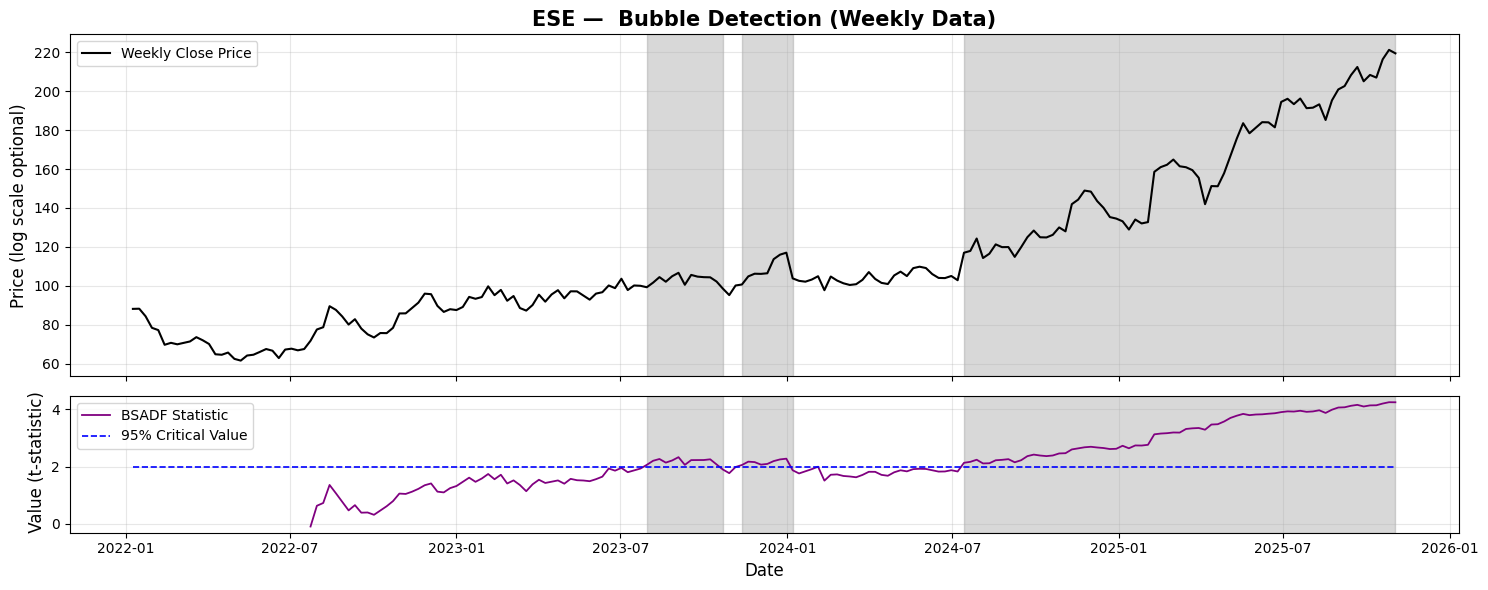

[INFO] ESE: 2022-01-09 → 2025-11-02  (n=200)
[INFO] 周终规则: W


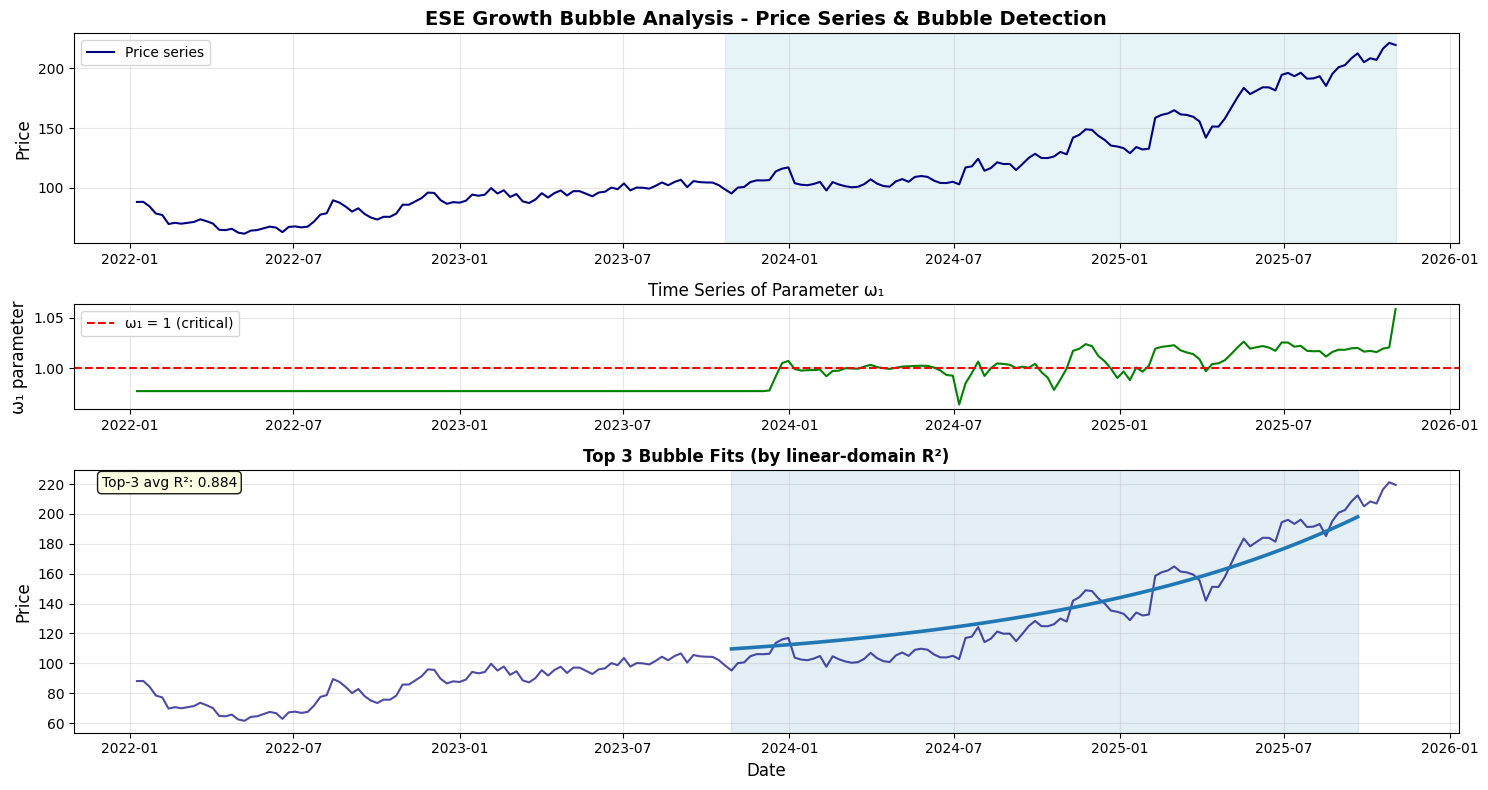

Detected bubbles: 22 / 191 windows
Avg ω₁: 1.0191 | Avg R²: 0.9749
Sample T=200, r0=0.1373, MIN_WIN=28
ADPT: GSADF=4.338 | Bubble Count=56


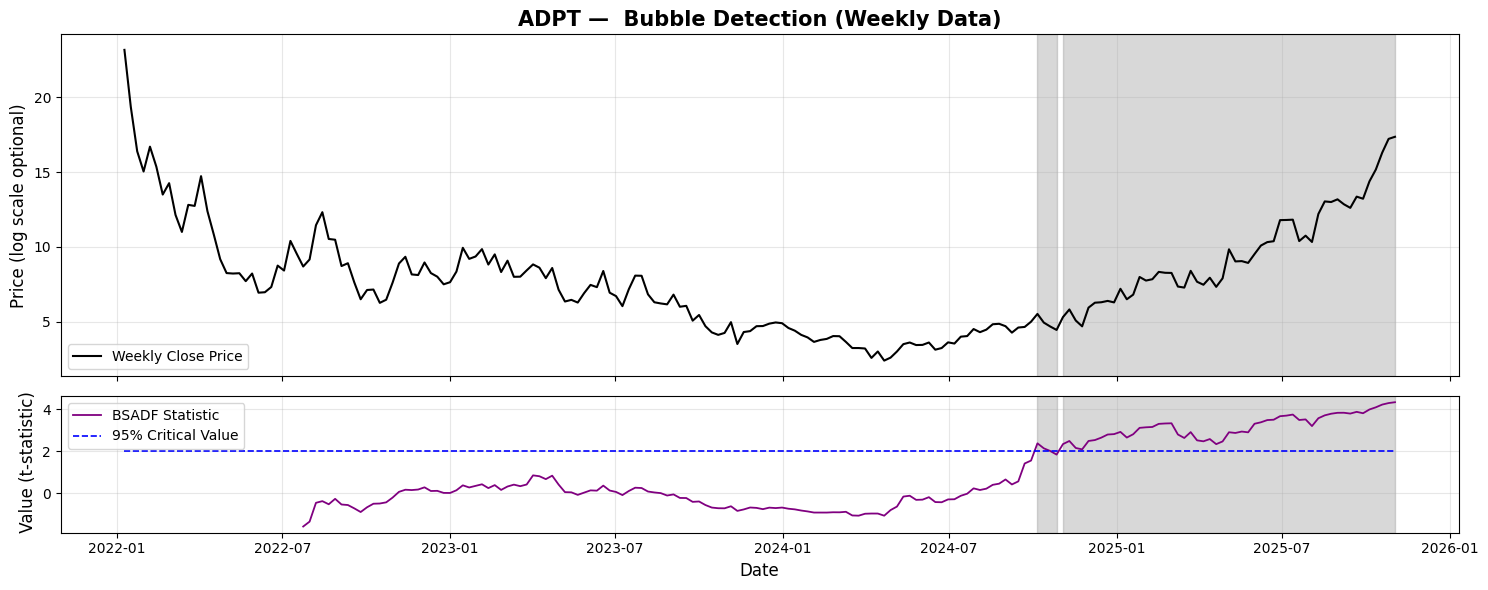

[INFO] ADPT: 2022-01-09 → 2025-11-02  (n=200)
[INFO] 周终规则: W


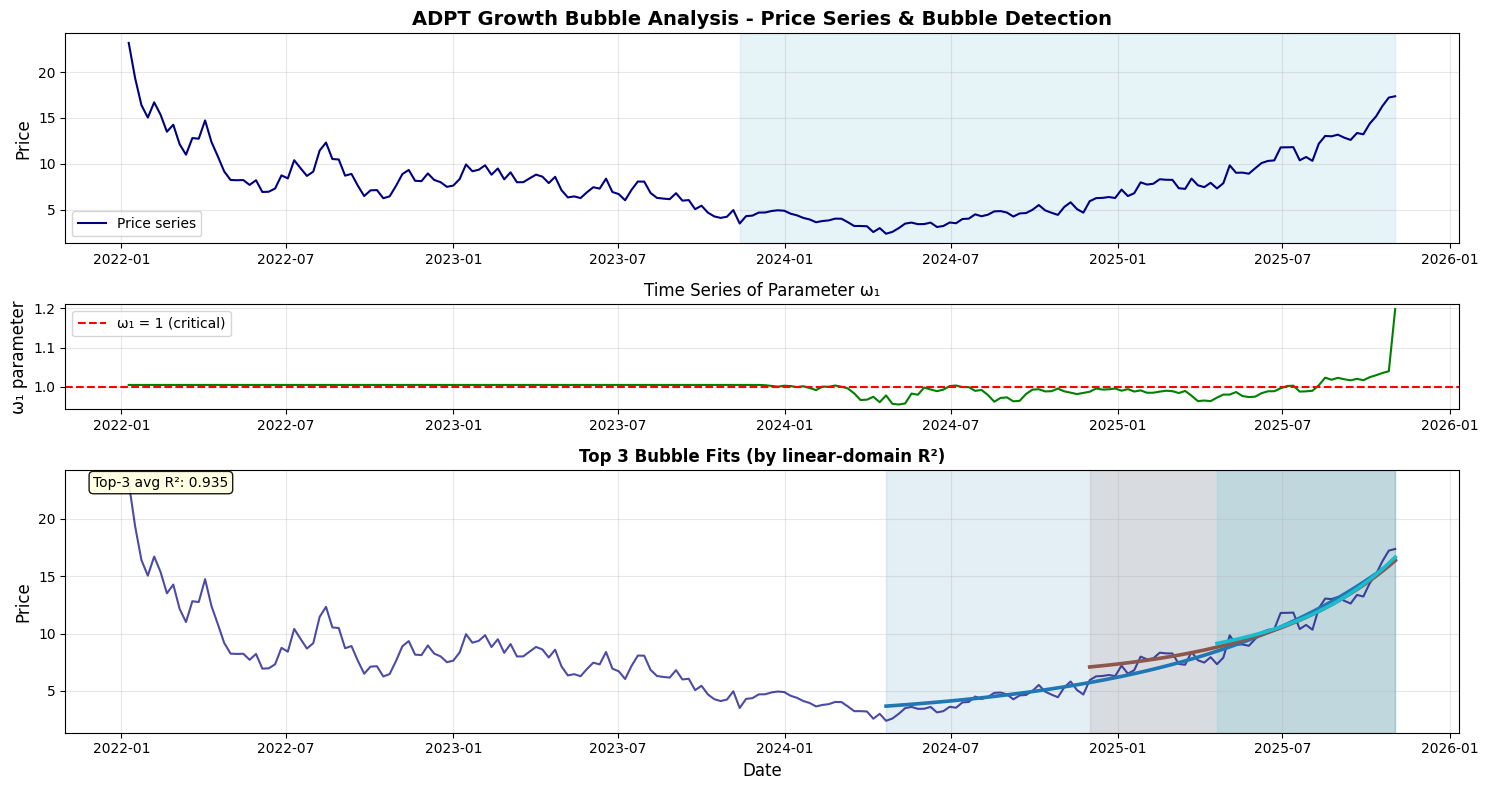

Detected bubbles: 89 / 191 windows
Avg ω₁: 1.0527 | Avg R²: 0.9467
Sample T=200, r0=0.1373, MIN_WIN=28
IFS: GSADF=4.039 | Bubble Count=54


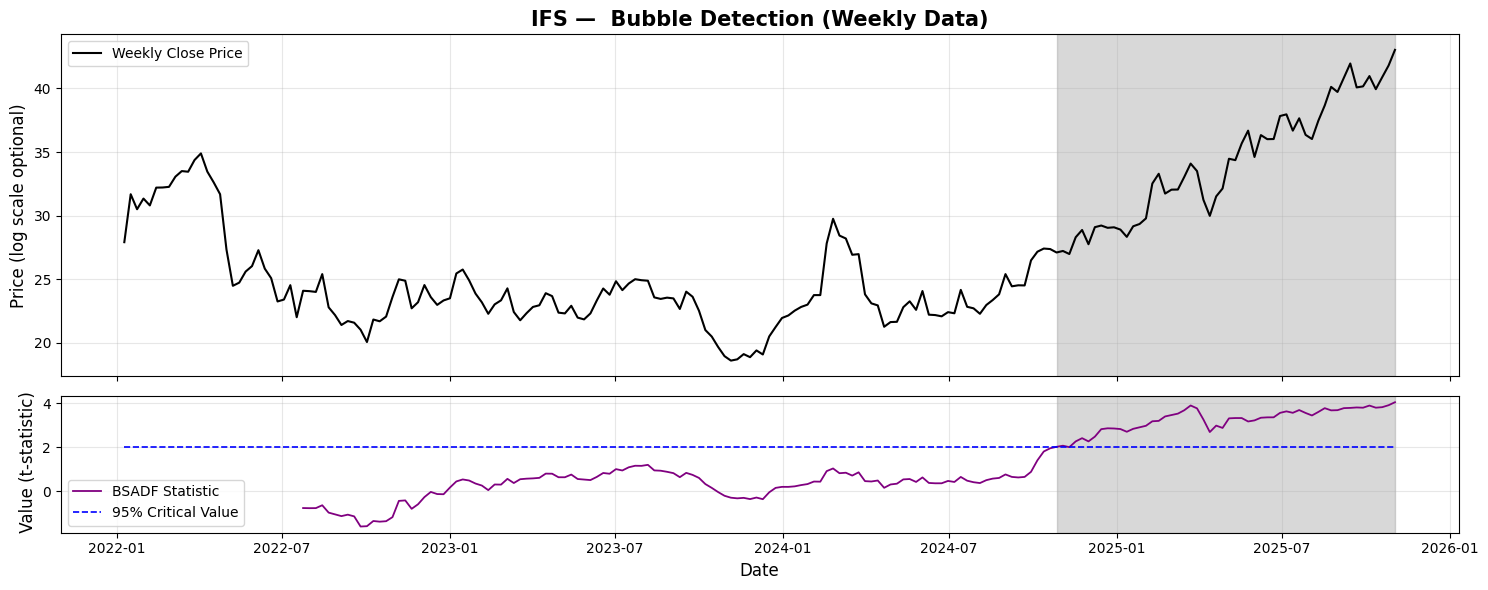

[INFO] IFS: 2022-01-09 → 2025-11-02  (n=200)
[INFO] 周终规则: W


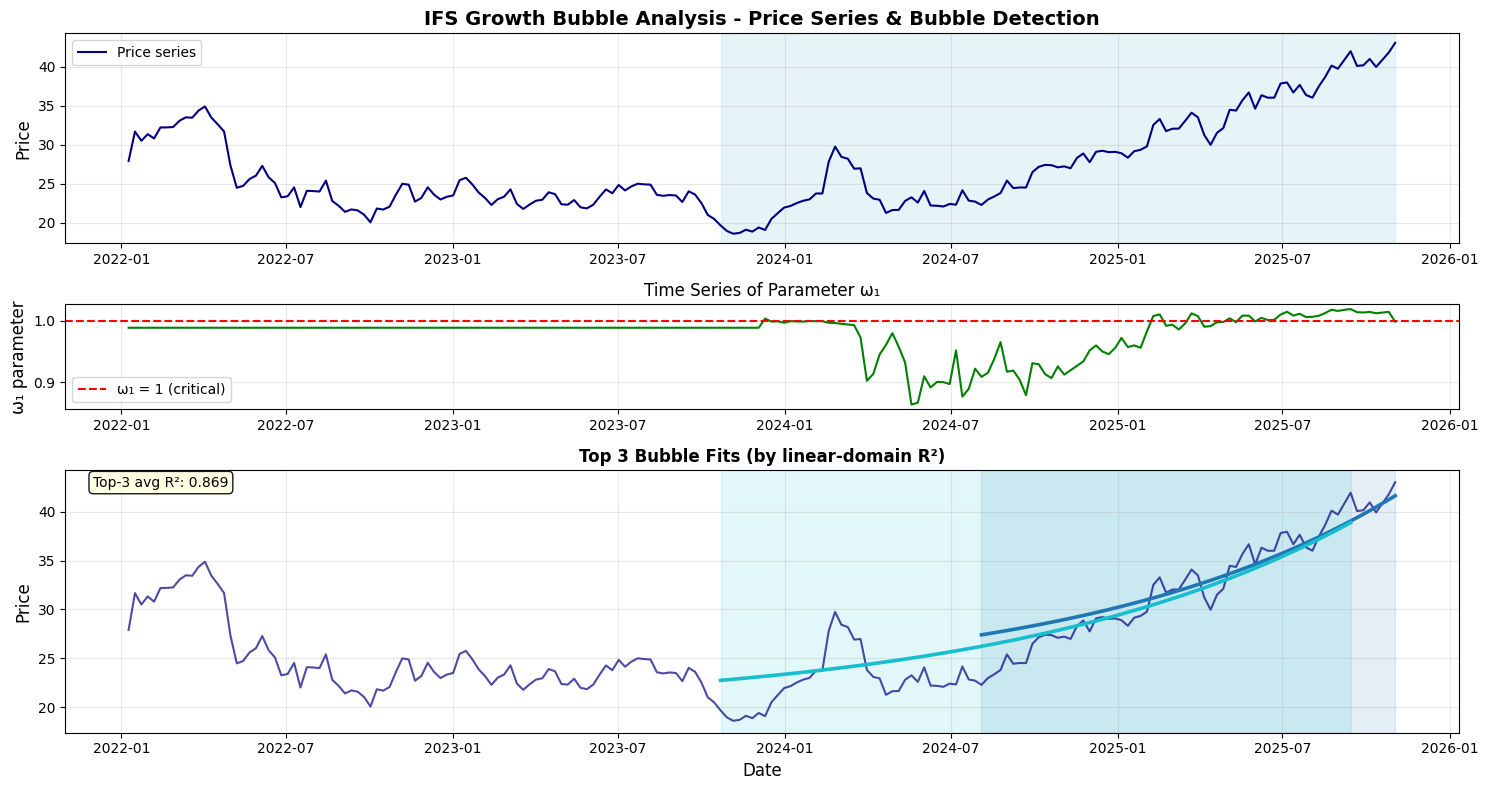

Detected bubbles: 16 / 191 windows
Avg ω₁: 1.0203 | Avg R²: 0.9665
Sample T=200, r0=0.1373, MIN_WIN=28
SRV.AX: GSADF=2.873 | Bubble Count=66


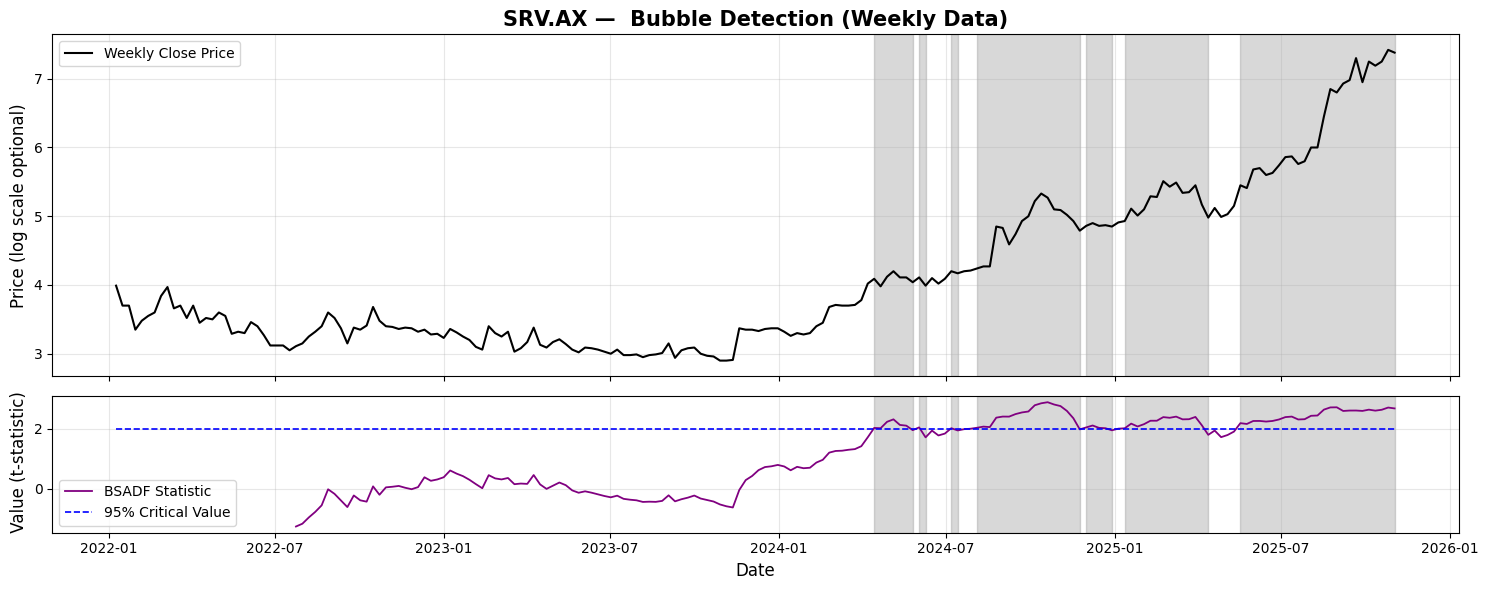

[INFO] SRV.AX: 2022-01-09 → 2025-11-02  (n=200)
[INFO] 周终规则: W


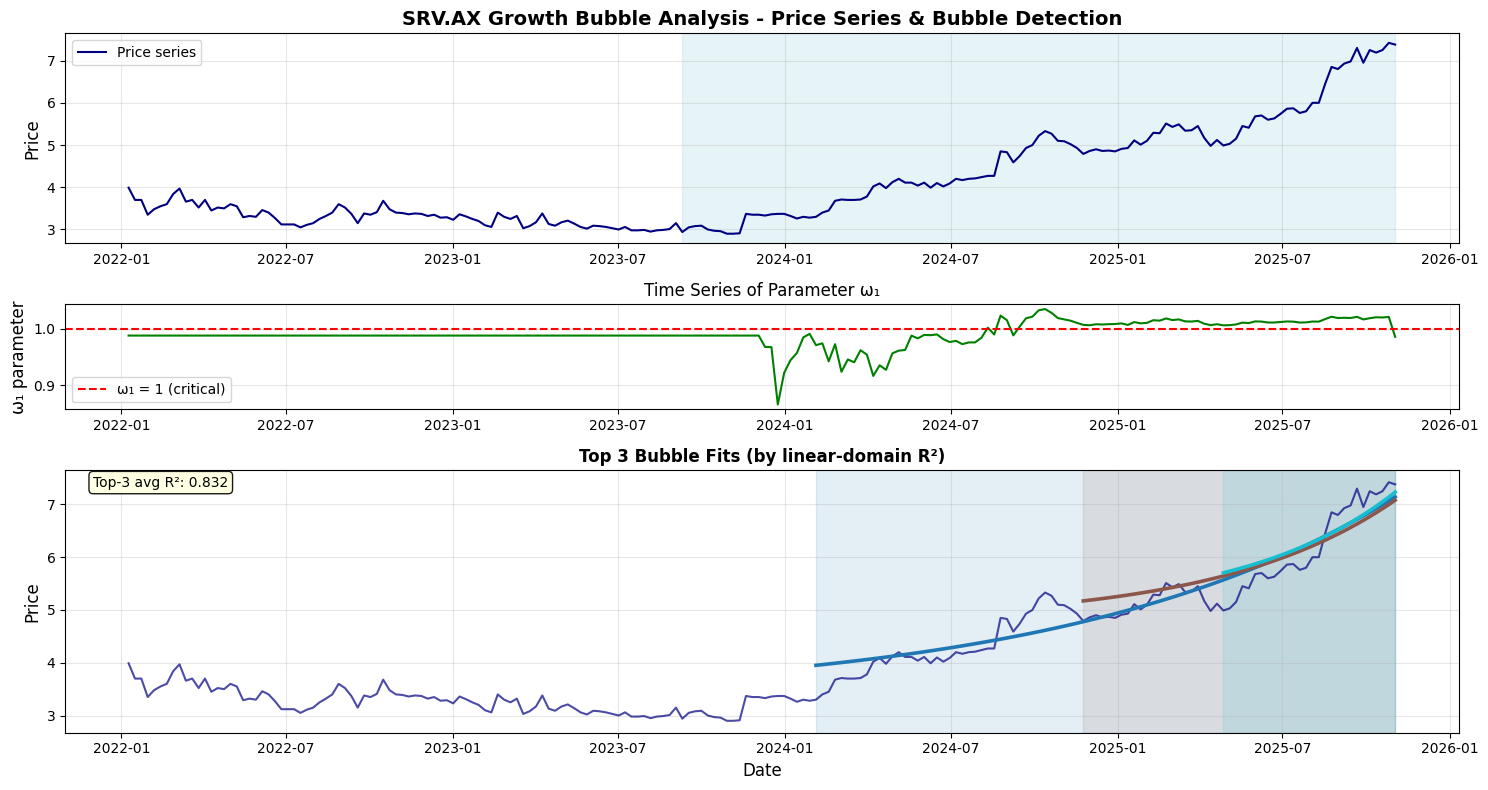

Detected bubbles: 69 / 191 windows
Avg ω₁: 1.0272 | Avg R²: 0.9687
Sample T=200, r0=0.1373, MIN_WIN=28
ROG: GSADF=2.759 | Bubble Count=19


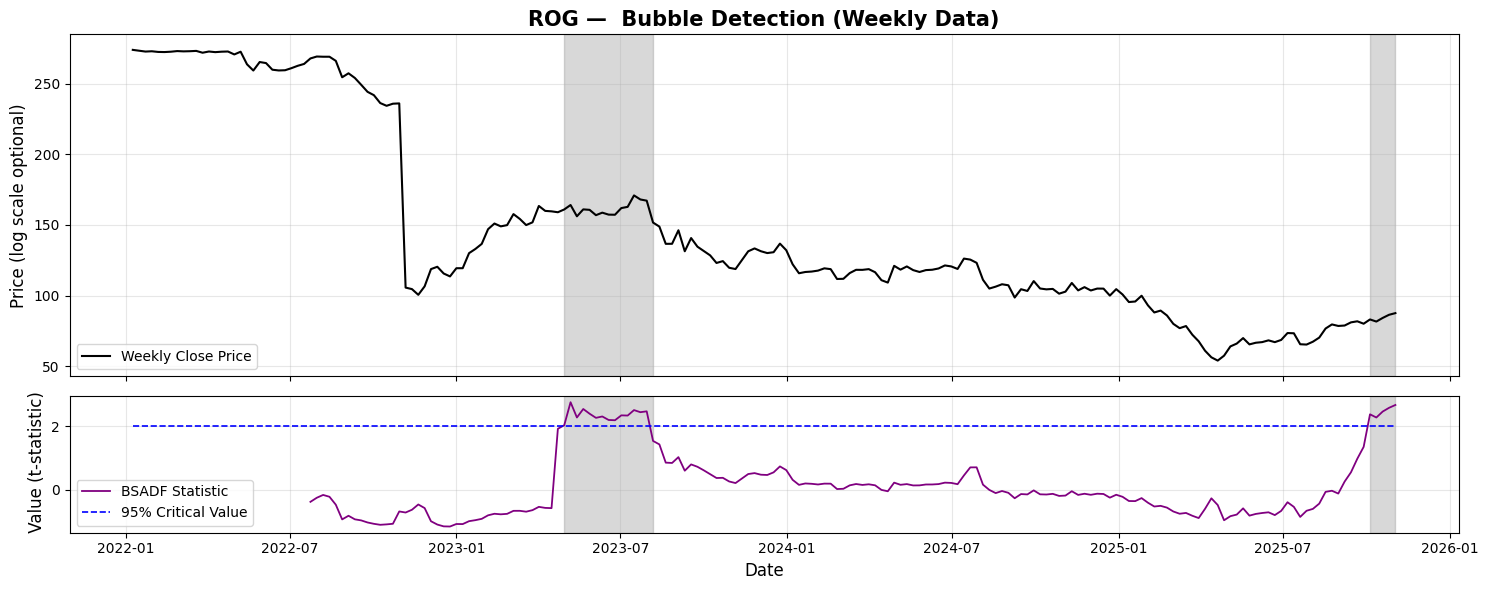

[INFO] ROG: 2022-01-09 → 2025-11-02  (n=200)
[INFO] 周终规则: W


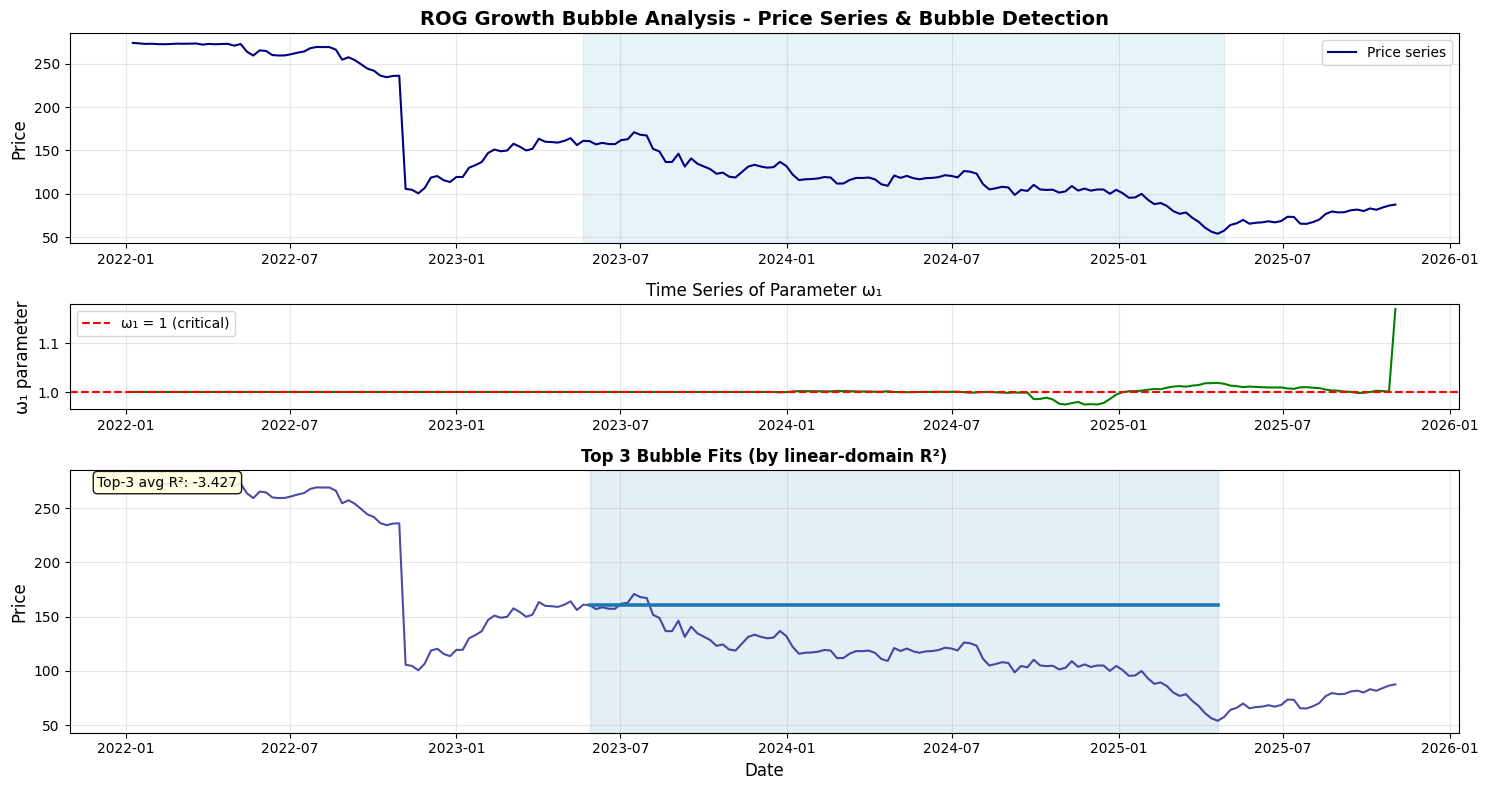

Detected bubbles: 2 / 191 windows
Avg ω₁: 1.0187 | Avg R²: 0.9544


In [7]:

for Symbol in Portfolio:
  run_gsadf(Symbol)
  signals = excf_from_symbol(
        sym=Symbol,
        start="2022-01-01",
        end="2025-10-31",
        api_key="490ed0ef6adef36a548539c3e6da425e",
        window=100,
        alpha=0.05,
        min_obs=10,
        week_rule="W",
        log_price=False,
        show_info=True
    )

开始处理 27 个股票代码...

正在为以下股票代码获取数据并绘图： ['MU', 'LFSC', 'HVAC', 'APH', 'ACES', 'NXT', 'TRVI', 'POWL', 'SSM.AX', 'PAXX.AX', 'VESG.AX', 'SRV.AX', 'IEM.AX', 'ALB', 'VMI', 'MU', 'NVDA', 'AYI', 'SCCO', 'GOOG', 'ANET', 'MPWR', 'GLL', 'FSLR', 'AMX', 'QCLN', 'AA']
--- Processing: MU ---
--- Processing: LFSC ---
--- Processing: HVAC ---
--- Processing: APH ---
--- Processing: ACES ---
--- Processing: NXT ---
--- Processing: TRVI ---
--- Processing: POWL ---
--- Processing: SSM.AX ---
--- Processing: PAXX.AX ---
--- Processing: VESG.AX ---
--- Processing: SRV.AX ---
--- Processing: IEM.AX ---
--- Processing: ALB ---
--- Processing: VMI ---
--- Processing: MU ---
--- Processing: NVDA ---
--- Processing: AYI ---
--- Processing: SCCO ---
--- Processing: GOOG ---
--- Processing: ANET ---
--- Processing: MPWR ---
--- Processing: GLL ---
--- Processing: FSLR ---
--- Processing: AMX ---
--- Processing: QCLN ---
--- Processing: AA ---
Plotting Info: Not enough historical data or invalid std dev for IEM.AX, S

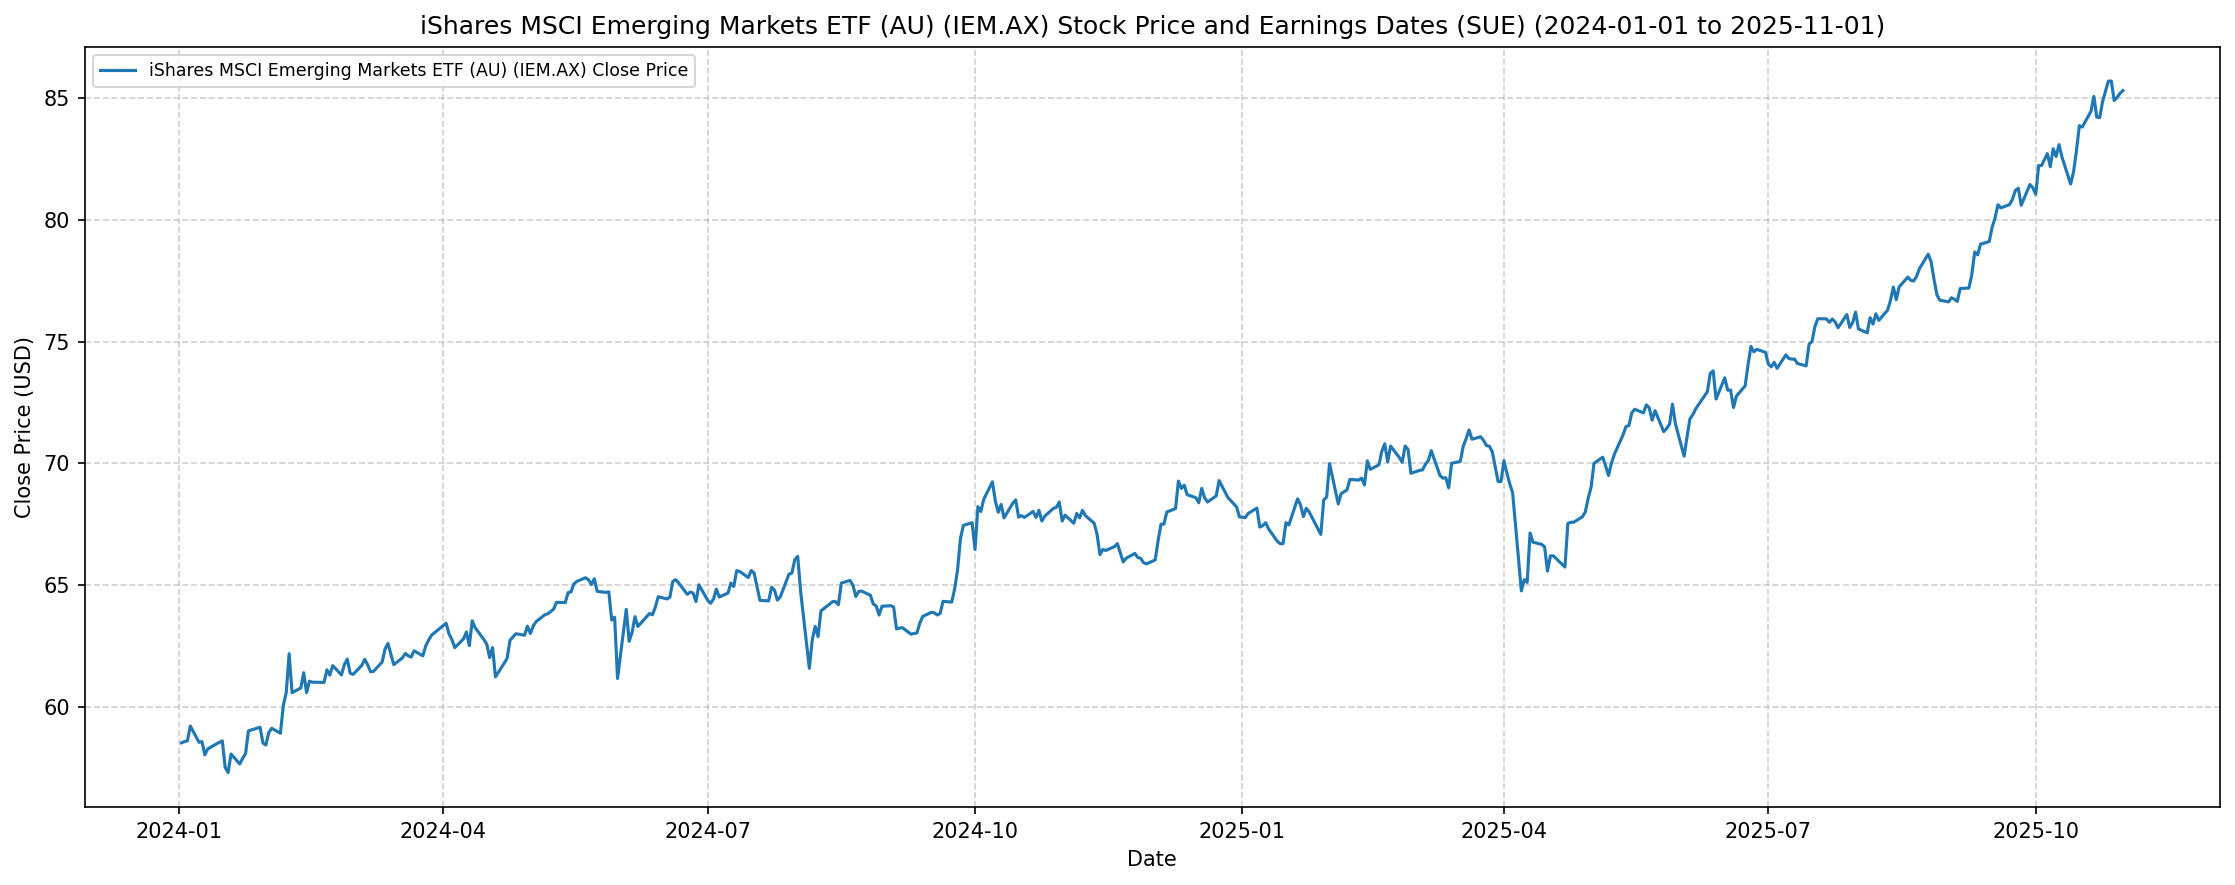

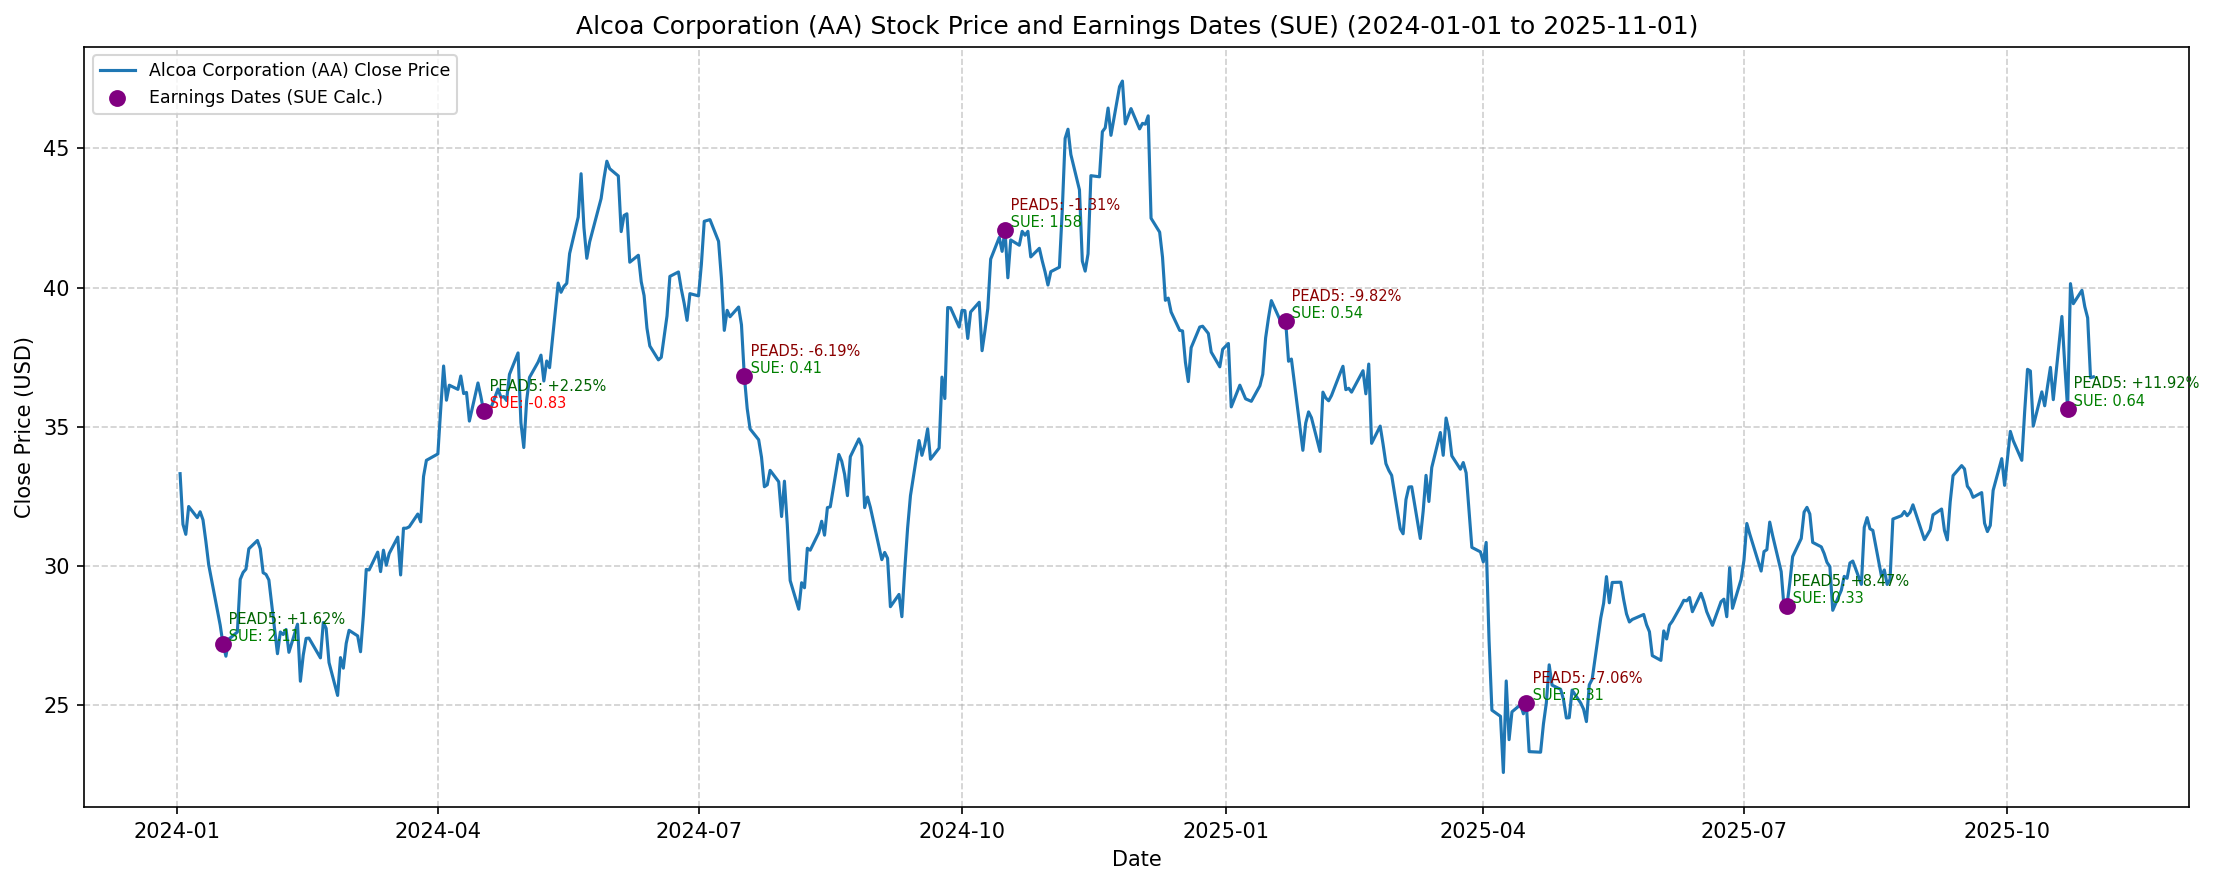

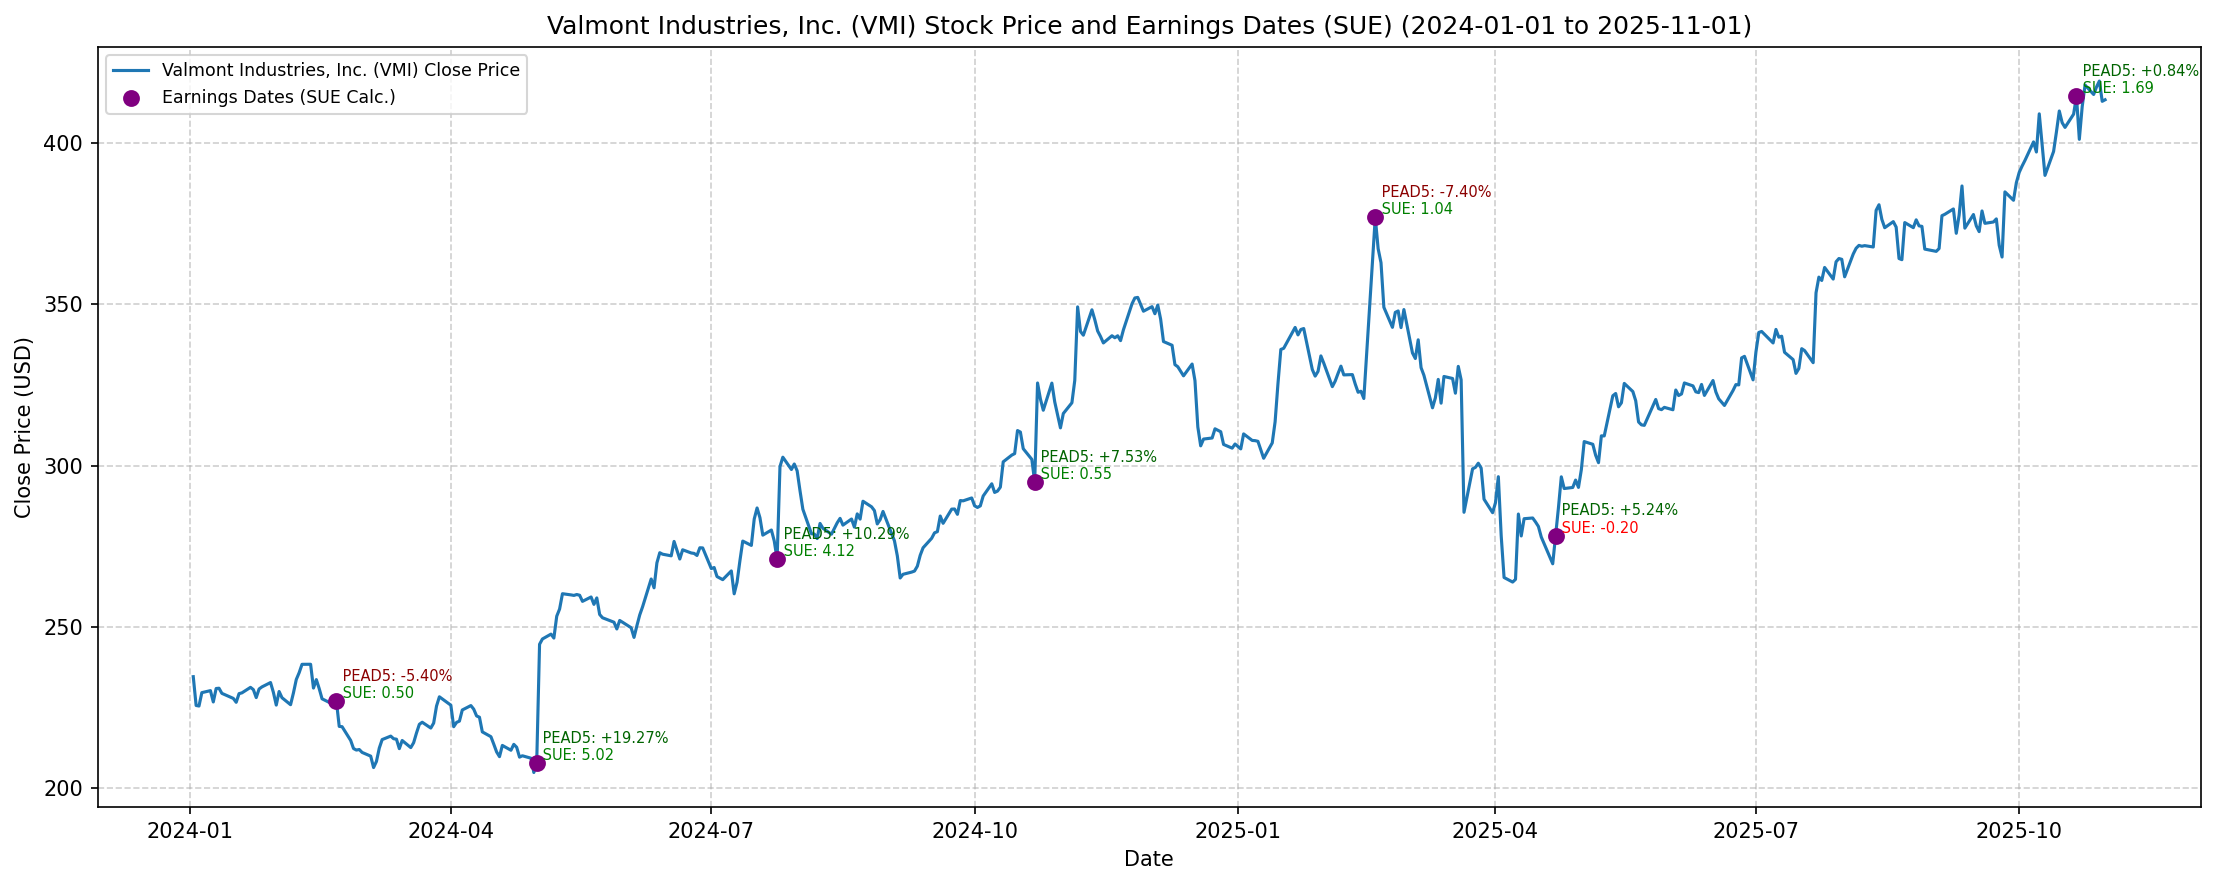

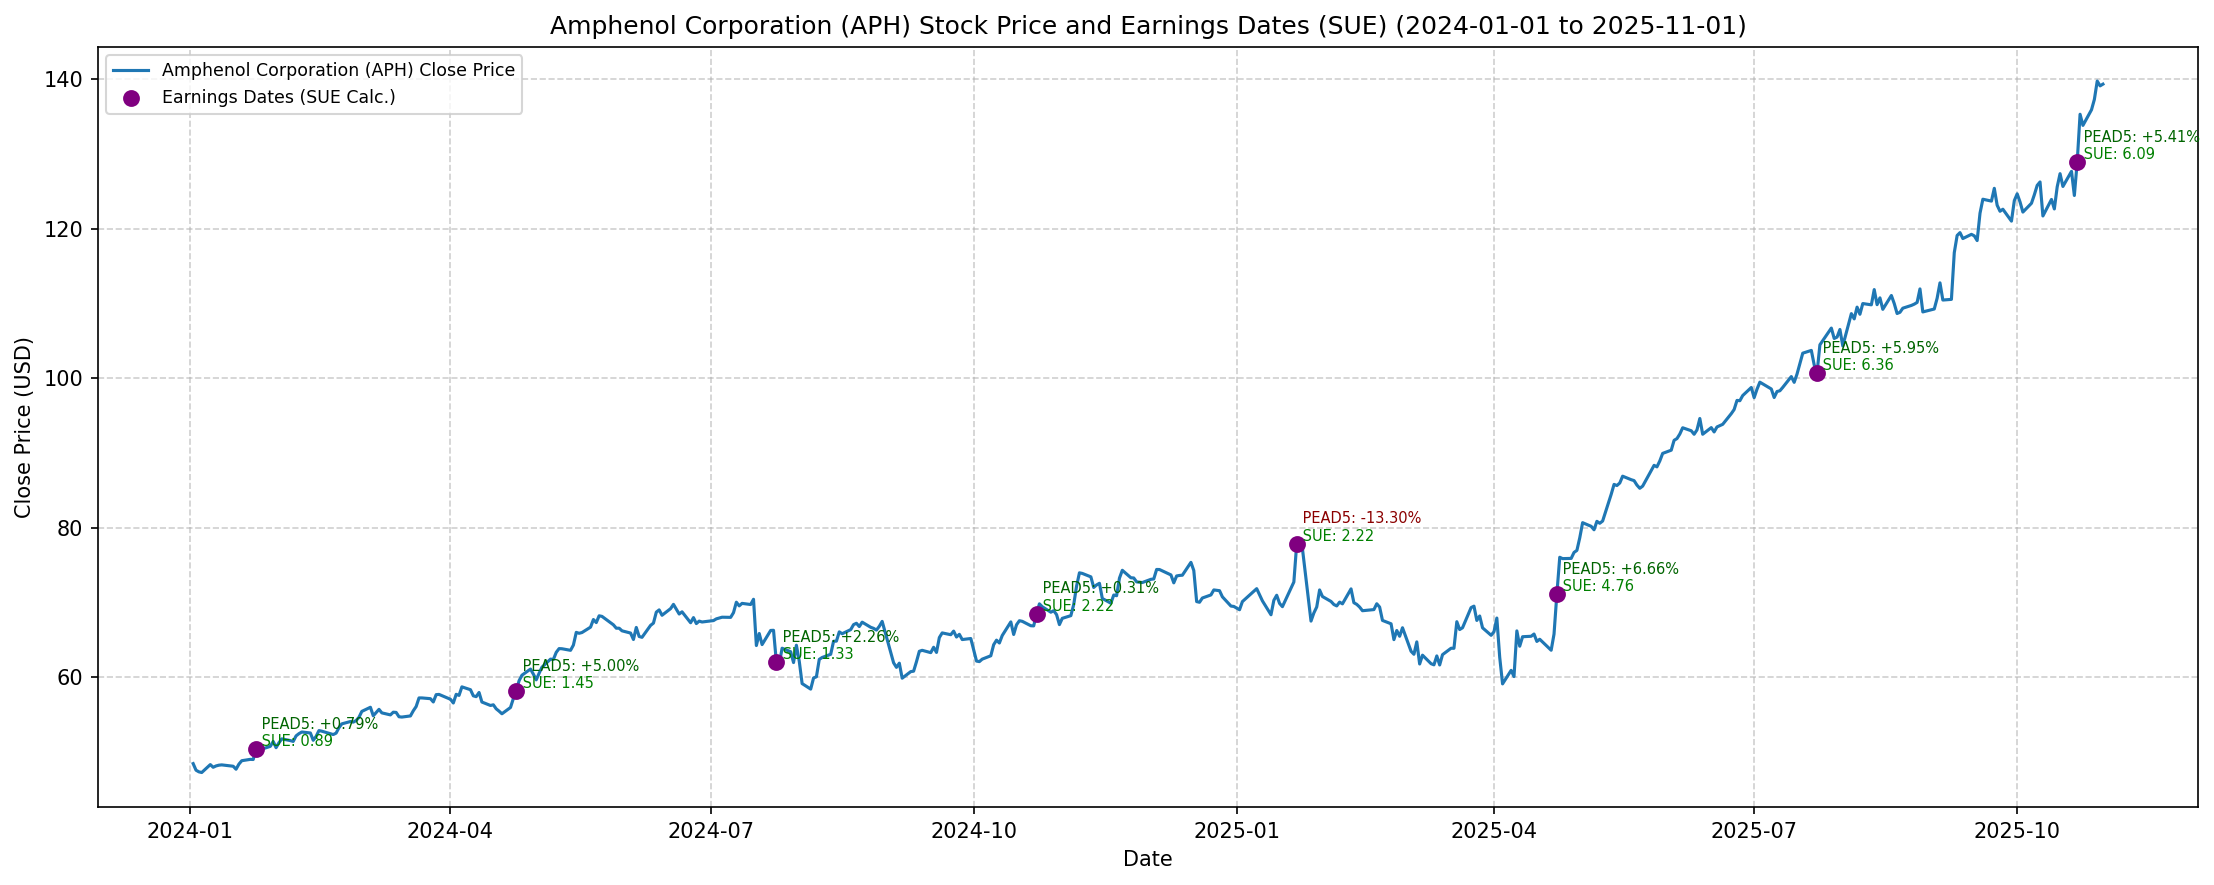

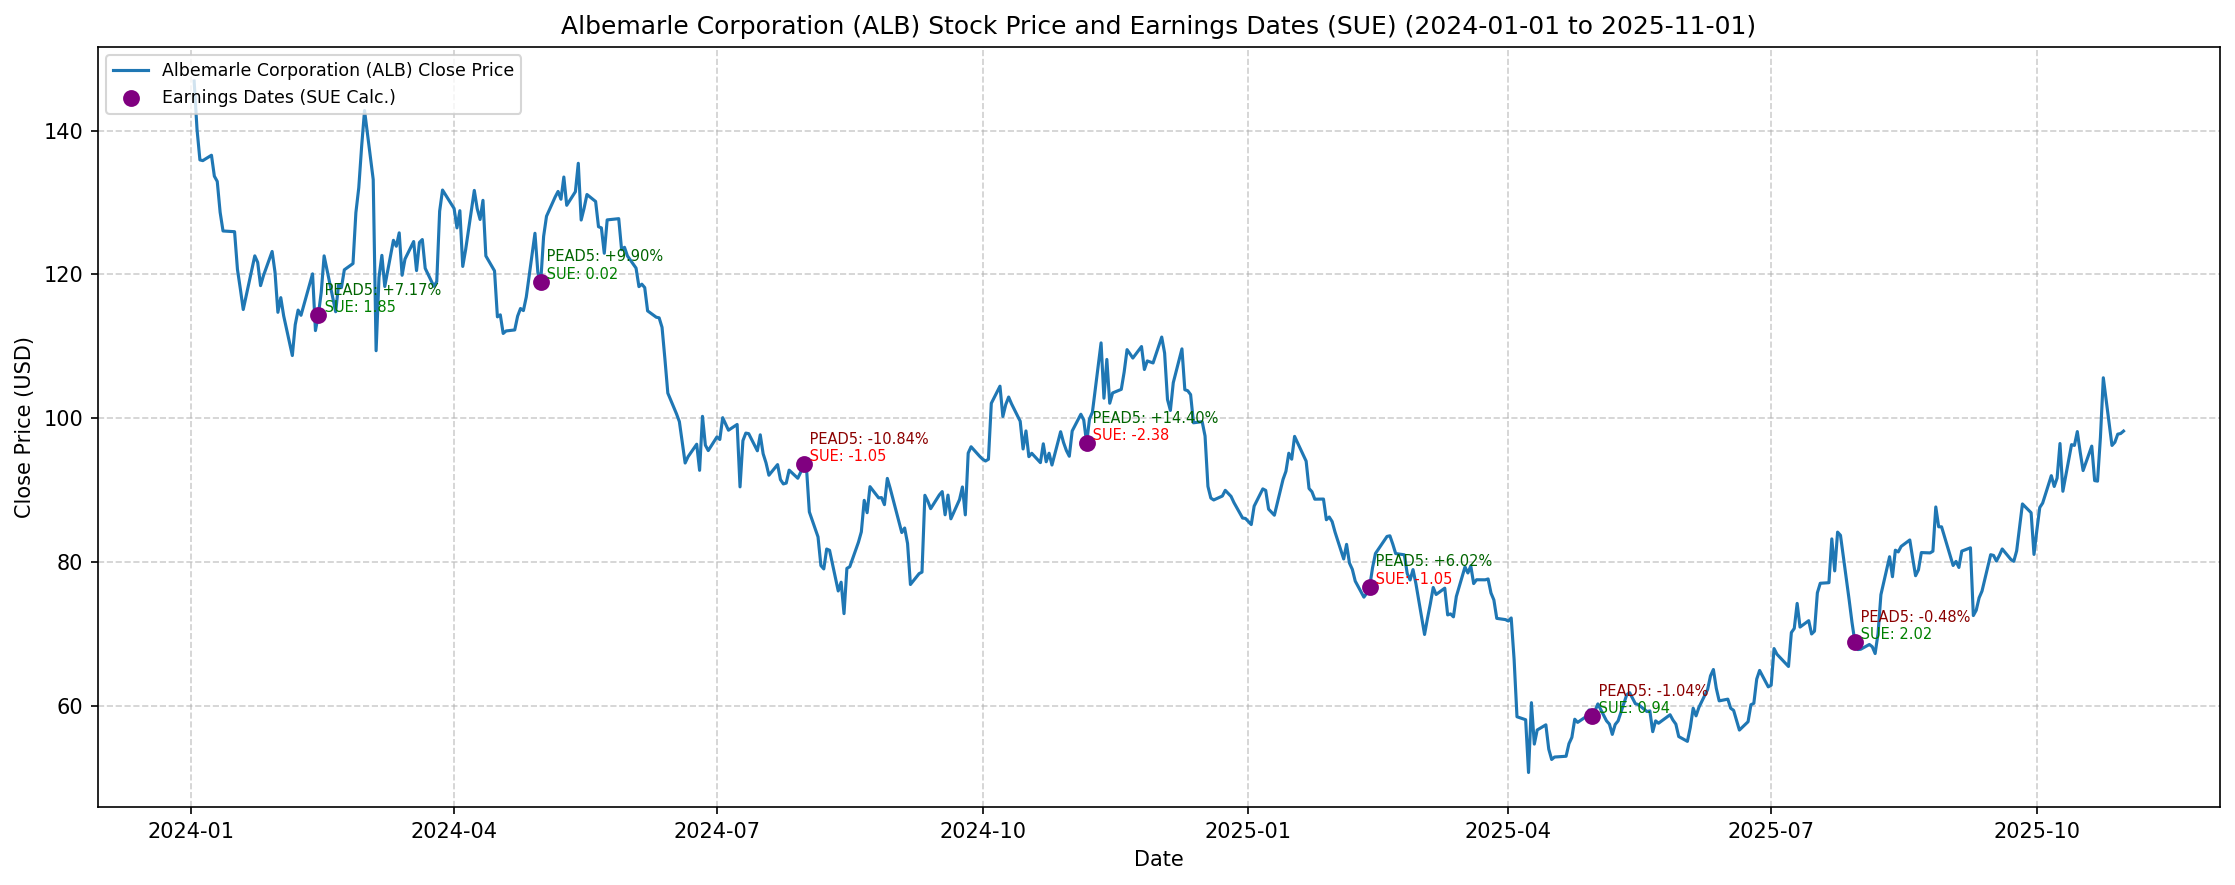

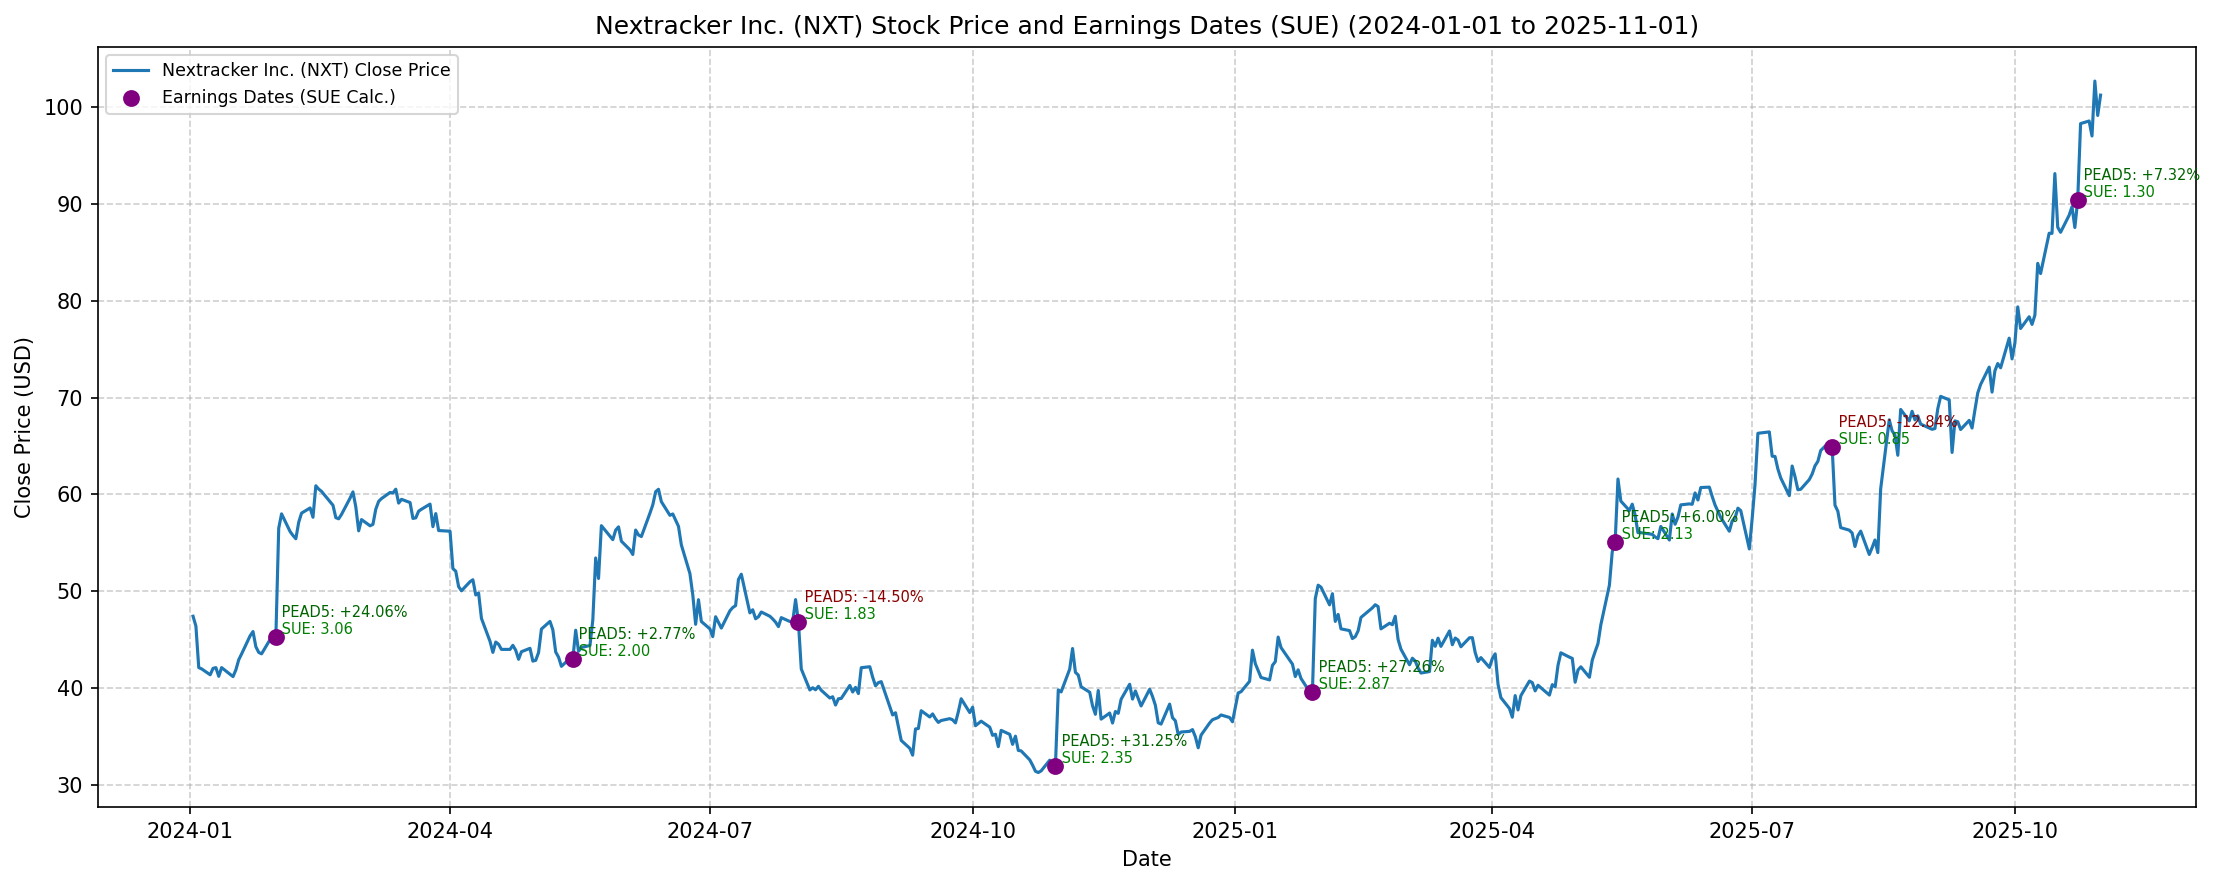

KeyboardInterrupt: 

In [47]:

import aiohttp
import asyncio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import nest_asyncio
import traceback

os.environ["FMP_API_KEY"] = 'd772bdc5c4ce6a58268173ab0b9e2d7d'
# --- Configuration ---
FMP_API_KEY = os.environ.get("FMP_API_KEY", "YOUR_API_KEY") # 请替换 "YOUR_API_KEY" 或设置环境变量
MIN_HISTORICAL_QUARTERS_FOR_SUE = 4 # 计算 SUE 标准差所需的最小历史季度数

# Async function to fetch JSON from FMP
async def fetch_json(session, url):
    """Fetches JSON data from a given URL using an aiohttp session."""
    try:
        async with session.get(url) as response:
            response.raise_for_status() # Raise an exception for bad status codes (4xx or 5xx)
            return await response.json()
    except aiohttp.ClientError as e:
        print(f"AIOHTTP Error fetching {url}: {e}")
    except Exception as e:
        print(f"General Error fetching {url}: {e}")
    return None

# --- Helper Function to Fetch Company Profile ---
async def fetch_company_profile(session, symbol, api_key):
    """Fetches company profile information (like name) from FMP."""
    profile_url = f"https://financialmodelingprep.com/api/v3/profile/{symbol}?apikey={api_key}"
    profile_data = await fetch_json(session, profile_url)
    if profile_data and len(profile_data) > 0:
        return profile_data[0] # Return the first profile found
    else:
        print(f"Warning: Could not fetch profile data for {symbol}.")
        return None

# --- Main Plotting Function (Modified for Ticker Input) ---
async def fetch_and_plot(session, symbol, start_date_str, end_date_str, api_key):
    """Fetches necessary data based on ticker and plots stock price with earnings annotations."""
    print(f"--- Processing: {symbol} ---")
    # Fetch company profile first to get the name
    profile_data = await fetch_company_profile(session, symbol, api_key)
    company_name = profile_data.get('companyName', symbol) if profile_data else symbol # Use symbol as fallback

    price_url = f"https://financialmodelingprep.com/api/v3/historical-price-full/{symbol}?from={start_date_str}&to={end_date_str}&apikey={api_key}"
    earnings_url = f"https://financialmodelingprep.com/api/v3/historical/earning_calendar/{symbol}?apikey={api_key}"

    try:
        price_data, earnings_data = await asyncio.gather(
            fetch_json(session, price_url),
            fetch_json(session, earnings_url)
        )

        if not price_data or 'historical' not in price_data or not price_data['historical']:
            print(f"No price data found for {symbol} between {start_date_str} and {end_date_str}")
            return # Skip plotting if no price data

        hist_df = pd.DataFrame(price_data['historical'])
        hist_df['date'] = pd.to_datetime(hist_df['date'])
        hist_df.sort_values('date', inplace=True)
        hist_df.set_index('date', inplace=True)

        # --- Process Historical Earnings & Calculate Std Dev ---
        historical_earnings_details = []
        if earnings_data:
            for earning in earnings_data:
                report_date_str = earning.get('date')
                eps_actual = earning.get('eps')
                eps_estimated = earning.get('epsEstimated')
                if report_date_str and eps_actual is not None and eps_estimated is not None:
                    try:
                        report_date = pd.to_datetime(report_date_str).normalize()
                        historical_earnings_details.append(
                            (report_date, float(eps_actual), float(eps_estimated))
                        )
                    except (ValueError, TypeError):
                        print(f"Warning: Could not parse date or EPS for {symbol} on {report_date_str}")

        historical_earnings_details.sort(key=lambda x: x[0])

        # Calculate standard deviation based on all available history before the end date
        # This gives a consistent reference for SUE calculation across the plot
        std_dev_surprise = None
        end_date_dt = pd.to_datetime(end_date_str).normalize()
        past_earnings = [e for e in historical_earnings_details if e[0] < end_date_dt] # Use all history before plot end

        if len(past_earnings) >= MIN_HISTORICAL_QUARTERS_FOR_SUE:
            past_surprises = [actual - estimated for _, actual, estimated in past_earnings]
            std_dev_surprise = np.std(past_surprises, ddof=1)
            if std_dev_surprise is None or np.isnan(std_dev_surprise) or std_dev_surprise < 1e-6:
                print(f"Warning: Invalid standard deviation ({std_dev_surprise}) calculated for {symbol} using data before {end_date_str}. SUE calculations might be affected.")
                std_dev_surprise = None # Treat as invalid

        # --- Calculate SUE for all plot points ---
        sue_info = [] # Store (date, sue_value)
        start_date_dt = pd.to_datetime(start_date_str).normalize() # Needed for filtering plot points
        if std_dev_surprise is not None:
            for date, actual, estimated in historical_earnings_details:
                # Only calculate/store SUE for dates within the plotting range
                if start_date_dt <= date <= end_date_dt:
                    surprise = actual - estimated
                    sue = surprise / std_dev_surprise
                    sue_info.append((date, sue))
        else:
            print(f"Plotting Info: Not enough historical data or invalid std dev for {symbol}, SUE annotations will be skipped.")

        # --- Plotting ---
        plt.figure(figsize=(15, 6))
        plt.plot(hist_df.index, hist_df['close'], label=f"{company_name} ({symbol}) Close Price", linewidth=1.5)

        # --- Mark Earnings Dates with SUE and PEAD Annotations ---
        if sue_info: # Only plot if SUE could be calculated
            plot_dates_with_sue = [info[0] for info in sue_info]
            # Filter dates that actually exist in the price data index
            plot_dates = [d for d in plot_dates_with_sue if d in hist_df.index]

            if plot_dates:
                date_to_sue_map = {info[0]: info[1] for info in sue_info}
                # Ensure unique index for lookup
                earnings_prices_series = hist_df.loc[plot_dates, 'close']
                if not earnings_prices_series.index.is_unique:
                    earnings_prices_series = earnings_prices_series[~earnings_prices_series.index.duplicated(keep='first')]
                    # Re-filter plot_dates based on the de-duplicated index
                    plot_dates = [d for d in plot_dates if d in earnings_prices_series.index]

                # Use the Series for plotting and lookup
                earnings_prices = earnings_prices_series.to_dict() # Convert to dict for easier lookup

                plt.scatter(list(earnings_prices.keys()), list(earnings_prices.values()),
                            color='purple', marker='o', s=50, zorder=5, label='Earnings Dates (SUE Calc.)')

                for date in plot_dates:
                    if date not in earnings_prices: # Double check date exists after potential filtering
                        continue

                    price = earnings_prices[date]
                    sue_val = date_to_sue_map.get(date)
                    if sue_val is None: continue # Should not happen if logic is correct

                    # Calculate PEAD 5d following this historical date
                    pead_calculated = False
                    pead_5d_val = None
                    start_price = price # Price on earnings date
                    pead_end_calc_date = date + timedelta(days=5)
                    # Ensure the end date for PEAD calculation is within the data range
                    pead_end_calc_date = min(pead_end_calc_date, hist_df.index.max())

                    if pead_end_calc_date > date:
                        try:
                            # Find the closest available trading day price on or after the target end date
                            # Using ffill to get the last known price if exact date is missing
                            # Need to ensure the index lookup is valid
                            if pead_end_calc_date >= hist_df.index.min():
                                # Get the index position, ensuring it's valid
                                end_idx_pos_arr = hist_df.index.get_indexer([pead_end_calc_date], method='ffill')
                                if len(end_idx_pos_arr) > 0 and end_idx_pos_arr[0] != -1:
                                     end_idx_pos = end_idx_pos_arr[0]
                                     # Check if the date found by ffill is actually after the start date
                                     if hist_df.index[end_idx_pos] >= date:
                                         end_price = hist_df['close'].iloc[end_idx_pos]
                                         if start_price is not None and end_price is not None and start_price > 1e-6:
                                             pead_5d_val = (end_price / start_price) - 1
                                             pead_calculated = True
                        except IndexError:
                             print(f"IndexError during PEAD calculation for {symbol} around {date}. Skipping PEAD annotation.")
                        except Exception as pe:
                            print(f"Error calculating PEAD for {symbol} around {date}: {pe}. Skipping PEAD annotation.")


                    # Add SUE text
                    sue_color = 'green' if sue_val >= 0 else 'red'
                    plt.text(date + timedelta(days=0.5), price, f" SUE: {sue_val:.2f}",
                             color=sue_color, fontsize=7, verticalalignment='bottom', rotation=0, zorder=6)

                    # Add PEAD text if calculated
                    if pead_calculated and pead_5d_val is not None:
                        pead_color = 'darkgreen' if pead_5d_val >= 0 else 'darkred'
                        vertical_offset = (hist_df['close'].max() - hist_df['close'].min()) * 0.025 # Offset based on price range
                        plt.text(date + timedelta(days=0.5), price + vertical_offset,
                                 f" PEAD5: {pead_5d_val*100:+.2f}%",
                                 color=pead_color, fontsize=7, verticalalignment='bottom',
                                 rotation=0, zorder=6)

        # --- Final Plot Adjustments ---
        plt.title(f"{company_name} ({symbol}) Stock Price and Earnings Dates (SUE) ({start_date_str} to {end_date_str})")
        plt.xlabel("Date")
        plt.ylabel("Close Price (USD)")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(loc='upper left', fontsize='small')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error processing {symbol}: {e}")
        print(traceback.format_exc())


# --- Main Function Modified for Ticker List Input ---
async def main(tickers_to_plot):
    """Orchestrates fetching and plotting for a list of stock tickers."""
    if FMP_API_KEY == "YOUR_API_KEY":
        print("错误：请将代码中的 'YOUR_API_KEY' 替换为您的实际 Financial Modeling Prep API 密钥，或设置 FMP_API_KEY 环境变量。")
        return

    if not tickers_to_plot:
        print("错误：需要提供一个包含股票代码的列表。")
        return

    start_date_str = '2024-01-01' # Example start date
    end_date_str = datetime.today().strftime('%Y-%m-%d')

    print(f"开始处理 {len(tickers_to_plot)} 个股票代码...")

    async with aiohttp.ClientSession() as session:
        plot_tasks = []
        for symbol in tickers_to_plot:
            if not isinstance(symbol, str) or not symbol.strip():
                print(f"警告：跳过无效的股票代码 '{symbol}'")
                continue
            # Create a task for each ticker
            plot_tasks.append(
                asyncio.create_task(
                    fetch_and_plot(
                        session=session,
                        symbol=symbol.strip().upper(), # Standardize ticker format
                        start_date_str=start_date_str,
                        end_date_str=end_date_str,
                        api_key=FMP_API_KEY
                    ), name=f"Plot_{symbol}"
                )
            )

        # Run plotting tasks concurrently
        if plot_tasks:
             print(f"\n正在为以下股票代码获取数据并绘图： {[t.get_name().split('_')[1] for t in plot_tasks]}")
             await asyncio.gather(*plot_tasks)
             print("\n所有绘图任务已完成。")
        else:
             print("\n没有有效的股票代码可供处理。")


if __name__ == "__main__":
    # --- Provide List of Tickers Here ---
    # tickers = ['AAPL', 'MSFT', 'NVDA', 'GOOG', 'TSLA', 'INVALIDTICKER'] # Example list including an invalid one
    tickers =Portfolio
    # Apply nest_asyncio
    nest_asyncio.apply()
    # Get the current event loop and run the main async function until it completes
    loop = asyncio.get_event_loop()
    loop.run_until_complete(main(tickers))



Processing 19 portfolio symbols + benchmark ...

==== Portfolio Scores (full list) ====
 symbol  total_score  current_price price_change_5d  volume_ratio  turnover_rate  volatility_pct market_cap_fmt
 IEM.AX     0.459267          85.31          -0.46%      2.837066       0.428711        0.844519         $1.40B
   MPWR     0.195796        1005.00          -6.50%      1.783185       2.099595        3.343276        $48.13B
   GOOG     0.145373         281.82          +8.18%      1.581492       0.240889        2.554446         $3.40T
   FSLR     0.117570         266.94         +10.58%      1.470278       2.738613        4.699707        $28.64B
   NVDA     0.084797         202.49          +8.71%      1.339189       0.916534        2.745526         $4.93T
VESG.AX     0.031249         114.19          +0.99%      1.124995       0.146706        0.378615         $1.31B
 SRV.AX     0.001184           7.38          -0.54%      1.004737       0.105893        2.028021       $730.25M
   POWL     0.00

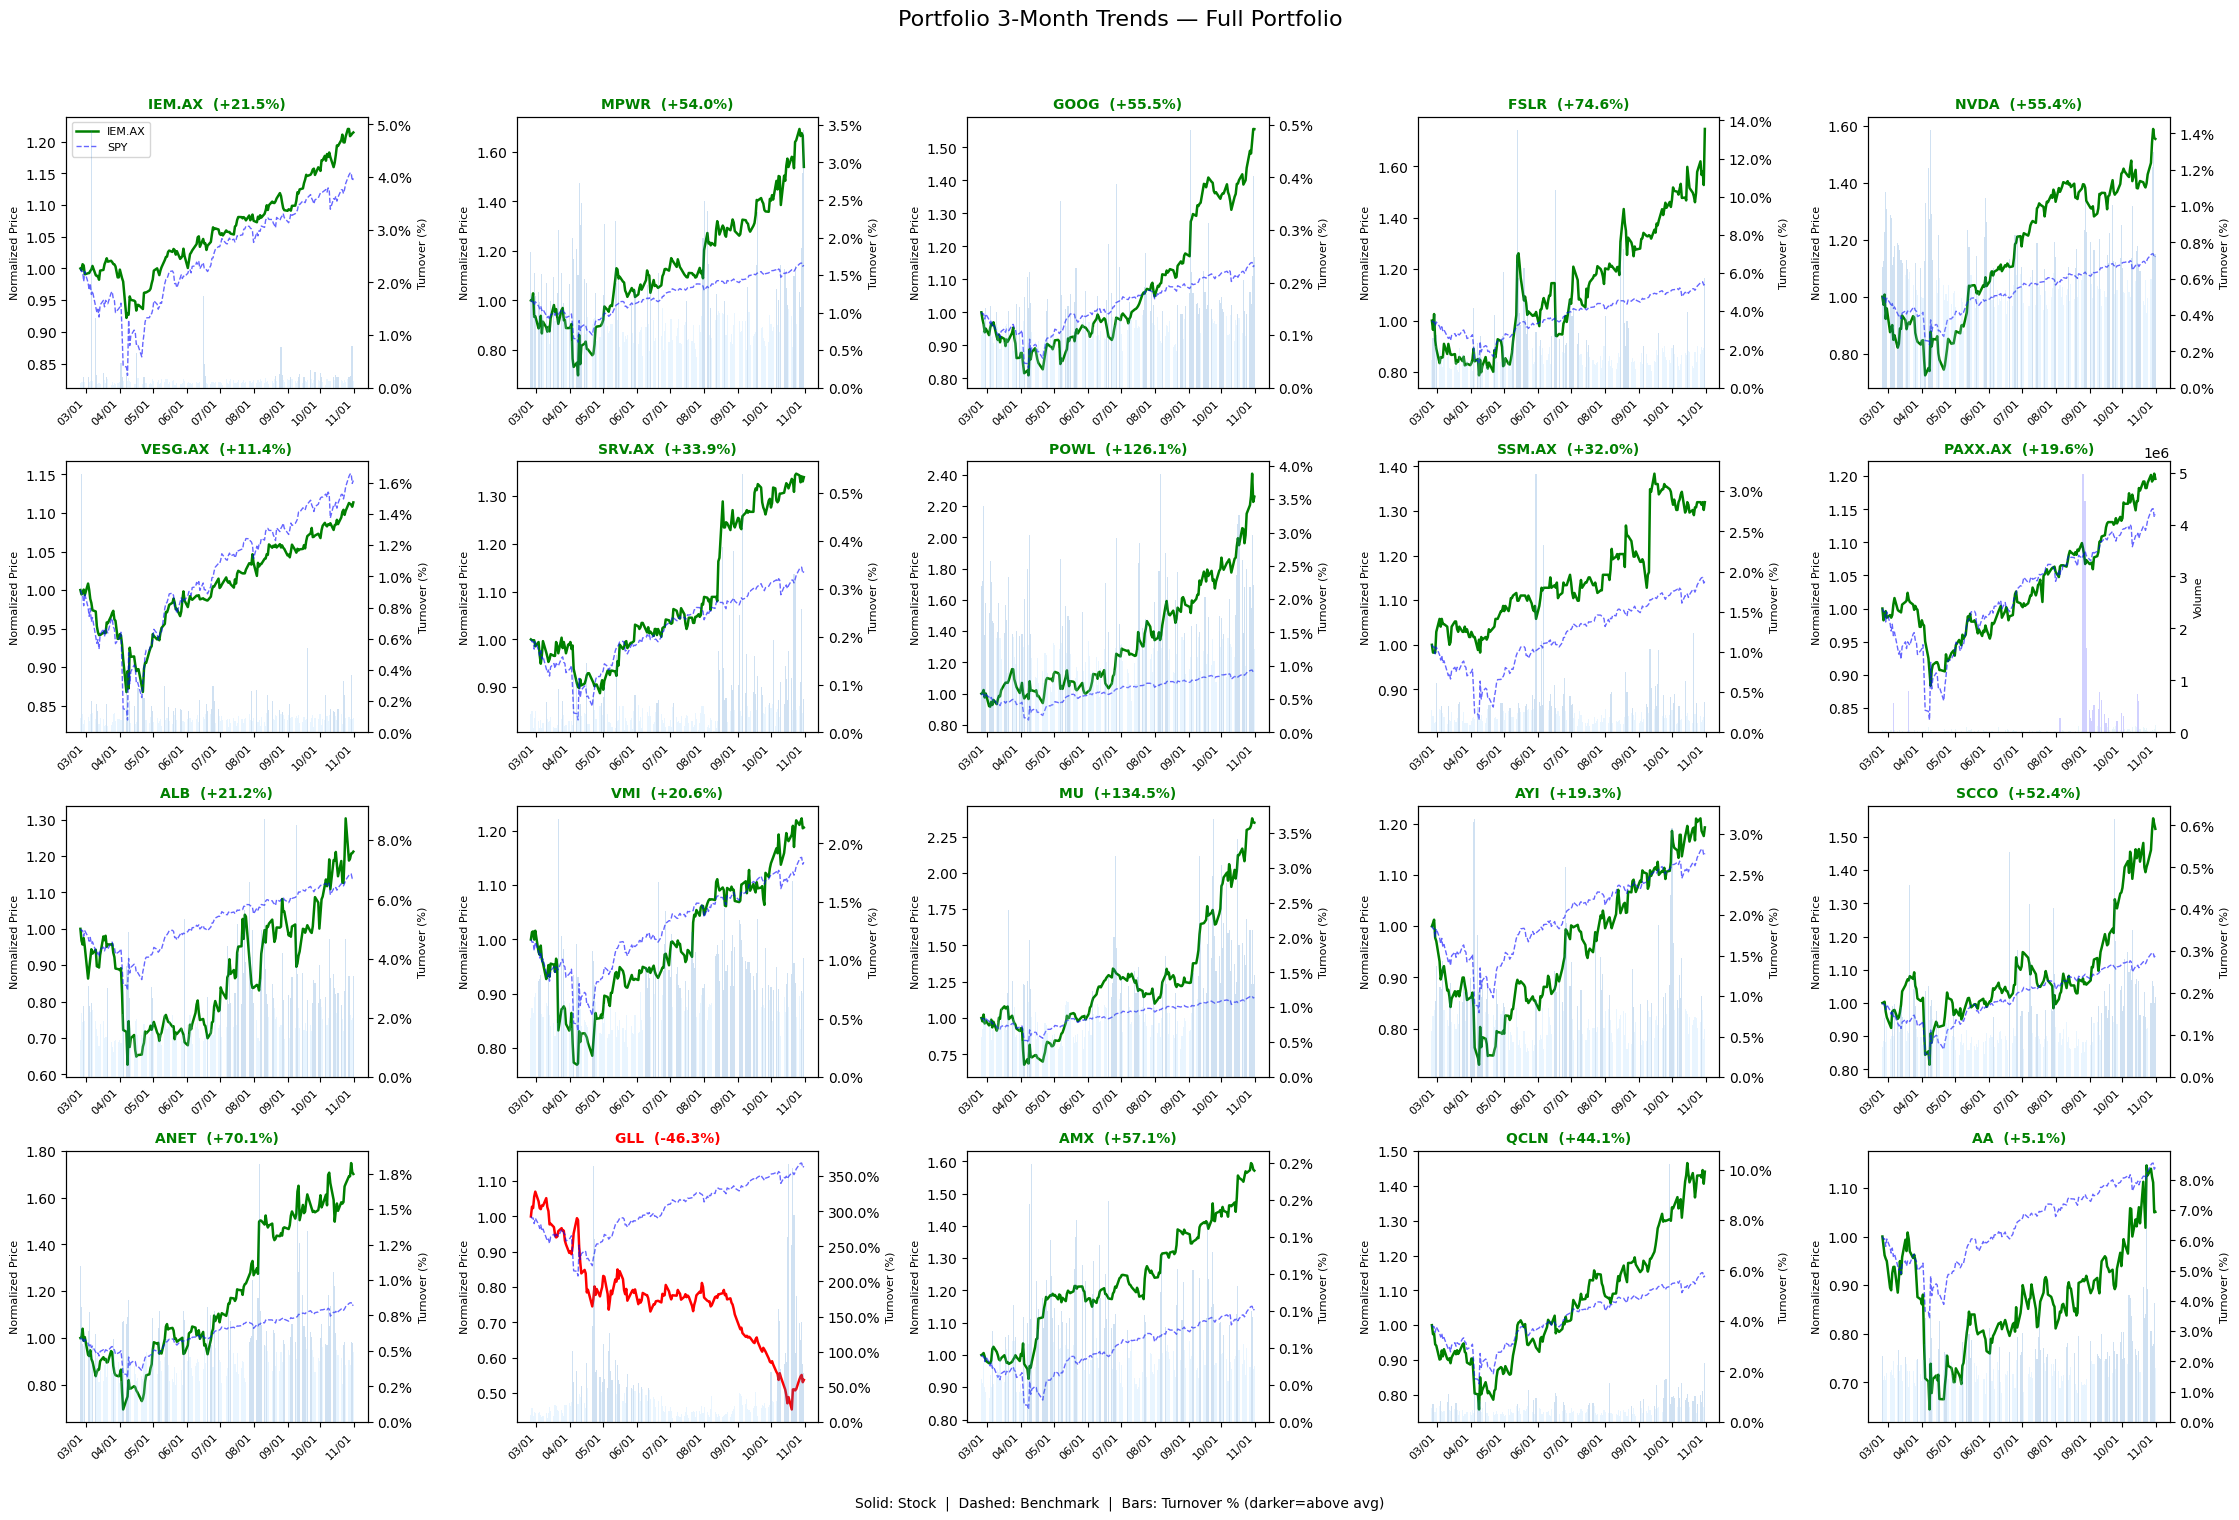

In [9]:
# -*- coding: utf-8 -*-
# KNK Research AI — Portfolio 热度打分 + 表格导出 + 3个月走势全量绘图（价格+换手率）
import aiohttp, asyncio, pandas as pd, numpy as np
from datetime import datetime, timedelta
import time, math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec

# ========= 配置 =========
PORTFOLIO = ['POWL','SSM.AX','PAXX.AX','VESG.AX','SRV.AX','IEM.AX','ALB','VMI',
             'MU','NVDA','AYI','SCCO','GOOG','ANET','MPWR','GLL','FSLR','AMX',
             'QCLN','AA']
BENCHMARK_SYMBOL = "SPY"       # 基准（可改：ASX 可用 'VAS.AX' 等）

# 打分权重（保留你给的）
WEIGHTS = {
    'volume_spike': 0.5,
    'turnover_rate': 0.0,
    'price_change_5d': 0.0,
    'volatility': 0.0,
}

SEMAPHORE_LIMIT = 10
API_KEY='d772bdc5c4ce6a58268173ab0b9e2d7d'

# ========= 基础异步请求 =========
async def fetch_data(session, url):
    async with session.get(url) as resp:
        if resp.status != 200:
            return None
        return await resp.json()

async def get_historical_data(session, symbol, semaphore):
    async with semaphore:
        today = datetime.now()
        from_date = (today - timedelta(days=250)).strftime('%Y-%m-%d')
        to_date = today.strftime('%Y-%m-%d')
        url = f"https://financialmodelingprep.com/api/v3/historical-price-full/{symbol}?from={from_date}&to={to_date}&apikey={API_KEY}"
        return symbol, await fetch_data(session, url)

async def get_company_profile(session, symbol, semaphore):
    async with semaphore:
        url = f"https://financialmodelingprep.com/api/v3/profile/{symbol}?apikey={API_KEY}"
        return symbol, await fetch_data(session, url)

# ========= 指标与打分 =========
def format_market_cap(mkt):
    if not mkt or not np.isfinite(mkt): return "N/A"
    if mkt >= 1e12: return f"${mkt/1e12:.2f}T"
    if mkt >= 1e9:  return f"${mkt/1e9:.2f}B"
    if mkt >= 1e6:  return f"${mkt/1e6:.2f}M"
    return f"${mkt:.0f}"

def calculate_volume_spike_score(hdata):
    if not hdata or 'historical' not in hdata or len(hdata['historical']) < 25:
        return 0, 0
    s = sorted(hdata['historical'], key=lambda x: x['date'], reverse=True)
    recent = [d['volume'] for d in s[:5] if d.get('volume')]
    prev20 = [d['volume'] for d in s[5:25] if d.get('volume')]
    if not recent or not prev20: return 0, 0
    r_avg = sum(recent)/len(recent)
    p_avg = sum(prev20)/len(prev20)
    if p_avg == 0: return 0, 0
    ratio = r_avg / p_avg
    score = 0
    if ratio > 1:
        score = min((ratio - 1)/2, 1)  # 3x≈满分
    return score, ratio

def calculate_turnover_rate(hdata, profile):
    if not hdata or 'historical' not in hdata: return 0, 0
    mkt = 0
    if profile and isinstance(profile, list) and len(profile) > 0:
        mkt = profile[0].get('mktCap', 0) or 0
    if mkt <= 0: return 0, 0
    s = sorted(hdata['historical'], key=lambda x: x['date'], reverse=True)
    vals = []
    for d in s[:5]:
        if d.get('close') and d.get('volume', 0) > 0:
            vals.append(d['close'] * d['volume'])
    if not vals: return 0, 0
    avg_val = sum(vals)/len(vals)
    tr = (avg_val / mkt) * 100
    score = min(tr/2, 1)  # 每日2%换手≈满分
    return score, tr

def calculate_price_change_score(hdata, days=5):
    if not hdata or 'historical' not in hdata or len(hdata['historical']) < days+1:
        return 0, 0
    s = sorted(hdata['historical'], key=lambda x: x['date'], reverse=True)
    cur = s[0]['close']; past = s[days]['close']
    if not past: return 0, 0
    pct = (cur/past - 1)*100
    highs = [d.get('high') for d in s[:days+1] if d.get('high') is not None]
    lows  = [d.get('low')  for d in s[:days+1] if d.get('low')  is not None]
    if highs and lows and max(highs) > min(lows):
        near_high = (cur - min(lows)) / (max(highs) - min(lows))
    else:
        near_high = 0.5
    change_score = min(abs(pct)/15, 1)
    score = change_score*0.7 + near_high*0.3
    return score, pct

def calculate_volatility_score(hdata):
    if not hdata or 'historical' not in hdata or len(hdata['historical']) < 10:
        return 0, 0
    s = sorted(hdata['historical'], key=lambda x: x['date'], reverse=True)
    rng = []
    for d in s[:10]:
        if all(k in d for k in ('high','low','close')) and d['close']>0:
            rng.append((d['high']-d['low'])/d['close'])
    if not rng: return 0, 0
    avg = np.mean(rng)*100
    if avg < 0.5: score = avg/0.5
    elif avg <= 5: score = 1.0
    else: score = max(0, 1.5 - (avg/10))
    return score, avg

# ========= 绘图（价格 + 换手率%） =========
def plot_three_month_price_trends(scores, three_month_data, benchmark_data, profiles, title_suffix=""):
    n = len(scores)
    if n == 0:
        print("No symbols to plot.")
        return
    # 每行最多5个
    cols = 5
    rows = math.ceil(n / cols)
    fig = plt.figure(figsize=(4.5*cols, 3.8*rows))  # 更清晰的比例
    gs = GridSpec(rows, cols, figure=fig)

    # 基准
    bench_hist = None
    if BENCHMARK_SYMBOL in benchmark_data:
        bench_hist = sorted(benchmark_data[BENCHMARK_SYMBOL].get('historical', []), key=lambda x: x['date'])
        if bench_hist:
            b0 = bench_hist[0]['close']
            bench_norm = [d['close']/b0 for d in bench_hist]
            bench_dates = [datetime.strptime(d['date'], '%Y-%m-%d') for d in bench_hist]

    for i, stock in enumerate(scores):
        sym = stock['symbol']
        r, c = divmod(i, cols)
        ax = fig.add_subplot(gs[r, c])

        hist = three_month_data.get(sym, {}).get('historical', [])
        if not hist:
            ax.text(0.5, 0.5, f"No data: {sym}", ha='center', va='center'); continue

        hist = sorted(hist, key=lambda x: x['date'])
        dates  = [datetime.strptime(d['date'], '%Y-%m-%d') for d in hist]
        prices = [d['close'] for d in hist]
        vols   = [d.get('volume', 0) for d in hist]

        # 归一化价格
        p0   = prices[0] if prices else 1
        norm = [p/p0 for p in prices]
        endp = prices[-1] if prices else 0
        pct  = (endp/p0 - 1)*100 if p0>0 else 0

        color = 'green' if endp >= p0 else 'red'
        ax.plot(dates, norm, color=color, linewidth=1.8, label=sym)
        ax.set_ylabel("Normalized Price", fontsize=8)

        # 基准（虚线）
        if bench_hist:
            ax.plot(bench_dates, bench_norm, 'b--', alpha=0.6, linewidth=1, label=BENCHMARK_SYMBOL)

        # ===== 副轴：换手率(%) =====
        ax2 = ax.twinx()
        mkt = 0
        prof = profiles.get(sym, [])
        if isinstance(prof, list) and prof:
            mkt = prof[0].get('mktCap', 0) or 0
        if mkt > 0:
            turnover_pct = [(p * v / mkt) * 100 for p, v in zip(prices, vols)]
            avg_to = np.nanmean(turnover_pct) if turnover_pct else 0
            bars_color = ['#9bd2ff' if t <= avg_to else '#2a78c5' for t in turnover_pct]
            ax2.bar(dates, turnover_pct, alpha=0.22, width=1, color=bars_color)
            ax2.set_ylabel("Turnover (%)", fontsize=8)
            ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.1f}%"))
        else:
            # 兜底：若无市值，用成交量
            avg_v = np.mean(vols) if vols else 0
            bars_color = ['skyblue' if v <= avg_v else 'blue' for v in vols]
            ax2.bar(dates, vols, alpha=0.18, width=1, color=bars_color)
            ax2.set_ylabel("Volume", fontsize=8)

        # X 轴 & 标题
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=8)

        t_color = 'green' if pct >= 0 else 'red'
        ax.set_title(f"{sym}  ({pct:+.1f}%)", color=t_color, fontsize=10, fontweight='bold')
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2f}'))
        if r == 0 and c == 0:
            ax.legend(loc='upper left', fontsize=8)

    plt.suptitle(f"Portfolio 3-Month Trends {title_suffix}", fontsize=16, y=0.995)
    fig.text(0.5, 0.01, "Solid: Stock  |  Dashed: Benchmark  |  Bars: Turnover % (darker=above avg)",
             ha='center', fontsize=10)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.savefig('portfolio_three_month_trends.png', dpi=300, bbox_inches='tight')

# ========= 主流程 =========
async def main():
    async with aiohttp.ClientSession() as session:
        semaphore = asyncio.Semaphore(SEMAPHORE_LIMIT)

        # 使用你的自定义 portfolio（不再取 S&P500）
        symbols = list(dict.fromkeys(PORTFOLIO))  # 去重保序
        # 确保包含基准
        if BENCHMARK_SYMBOL not in symbols:
            symbols.append(BENCHMARK_SYMBOL)

        print(f"Processing {len(PORTFOLIO)-1} portfolio symbols + benchmark ...")

        tasks_hist = [get_historical_data(session, s, semaphore) for s in symbols]
        tasks_prof = [get_company_profile(session, s, semaphore) for s in symbols]

        hist_results = {s: d for s, d in (await asyncio.gather(*tasks_hist)) if d}
        prof_results = {s: d for s, d in (await asyncio.gather(*tasks_prof)) if d}

        benchmark_data = hist_results.get(BENCHMARK_SYMBOL, {})

        # 打分（对 portfolio 全量，不截前N）
        scores = []
        for s in symbols:
            if s == BENCHMARK_SYMBOL:  # 跳过基准本身
                continue
            h = hist_results.get(s, {})
            p = prof_results.get(s, [])

            vscore, vr = calculate_volume_spike_score(h)
            tscore, tr = calculate_turnover_rate(h, p)
            cscore, cpct = calculate_price_change_score(h, days=5)
            oscore, ov = calculate_volatility_score(h)

            total = (
                WEIGHTS['volume_spike'] * vscore +
                WEIGHTS['turnover_rate'] * tscore +
                WEIGHTS['price_change_5d'] * cscore +
                WEIGHTS['volatility'] * oscore
            )

            # 当前价 & 5日涨跌
            cur = "N/A"; change_5d = "N/A"
            if 'historical' in h and h['historical']:
                srt = sorted(h['historical'], key=lambda x: x['date'], reverse=True)
                cur = srt[0]['close']
                if len(srt) >= 6:
                    ch = (srt[0]['close']/srt[5]['close'] - 1) * 100
                    change_5d = f"{ch:+.2f}%"

            mkt = p[0].get('mktCap', 0) if (isinstance(p, list) and p) else 0

            scores.append({
                'symbol': s,
                'total_score': total,
                'current_price': cur,
                'price_change_5d': change_5d,
                'price_change_pct': cpct,
                'volume_spike_score': vscore,
                'volume_ratio': vr,
                'turnover_score': tscore,
                'turnover_rate': tr,
                'price_change_score': cscore,
                'volatility_score': oscore,
                'volatility_pct': ov,
                'market_cap': mkt,
                'market_cap_fmt': format_market_cap(mkt),
            })

        # 排序仅用于展示顺序；不截前N
        scores.sort(key=lambda x: x['total_score'], reverse=True)

        # 输出表格（全量）
        df = pd.DataFrame(scores)
        cols_order = ['symbol','total_score','current_price','price_change_5d',
                      'volume_ratio','turnover_rate','volatility_pct','market_cap_fmt']
        for col in cols_order:
            if col not in df.columns: df[col] = np.nan
        df_show = df[cols_order].copy()
        print("\n==== Portfolio Scores (full list) ====")
        print(df_show.to_string(index=False))

        # 画图（全量，副轴为换手率%）
        plot_three_month_price_trends(
            scores,
            hist_results,
            {BENCHMARK_SYMBOL: benchmark_data},
            prof_results,
            title_suffix="— Full Portfolio"
        )

if __name__ == "__main__":
    start = time.time()
    await (main())   # 在脚本中用 asyncio.run
    print(f"\n Runtime: {time.time()-start:.2f}s")
